<div style="font-size: 30px">
    <b>Проект- промышленность</b>
</div>

<a id='plan'></a>
<div style="font-size: 20px">
    План работы
    </div>
    
1. описание проекта, постановка задачи
2. изучение данных:
 - выгрузка данных
 - исследовательский анализ (head, info, describe, isna, etc)
 - графики распределений признаков
 - выводы
3. предобработка данных
 - типы данных
 - пропуски
 - аномалии
 - корреляции
4. подготовка данных
 - генерация/отбор фичей
 - отбор признаков
 - формирование итогового датафрейма
 - масштабирование
 - разделение на тренировочную и тестовую выборки
5. подбор модели
 - обучение моделей
 - подбор гиперпараметров
 - выделение лучшей модели
6. тестирование модели
 - анализ важности фичей
 - тест чемпиона на тестовой выборке
7. вывод

#  Описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

<div style="font-size: 20px">
    Описание этапа обработки
    </div>
    
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.<br>
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).<br>
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.<br>
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

<div style="font-size: 20px">
    Описание данных
    </div>
    
Данные состоят из файлов, полученных из разных источников:<br>
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

# изучение данных

In [116]:
# импорты
import os

import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [117]:
RANDOM_STATE = 161023
TEST_SIZE=0.25

In [118]:
# функция для загрузки/вывода общей информации по датфрейму
def data_load_stat(data):
    path1 = f'/datasets/{data}.csv'
    path2 = f'{data}.csv'
    if os.path.exists(path1):
        path = path1

    elif os.path.exists(path2):
        path = path2
    else:
        print('данные не загружены')
        return
    df = pd.read_csv(path)
    print('пример данных')
    display(df.head(2))
    print('\n\nобщая информация')
    df.info()
    print('\n\nстатистика распределения')
    display(df.describe())
    print('\n\nполные дубли')
    display(df.duplicated().sum())
    print('\n\nпропуски')
    display(df.isna().sum())
    return df

## исследование датафрейма с данными об электродах

In [119]:
print('общая информация данных об электродах')
data_arc_new = data_load_stat('data_arc_new')

общая информация данных об электродах
пример данных


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   

   Реактивная мощность  
0             0.211253  
1             0.477438



общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


статистика распределения


key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284



полные дубли


0



пропуски


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

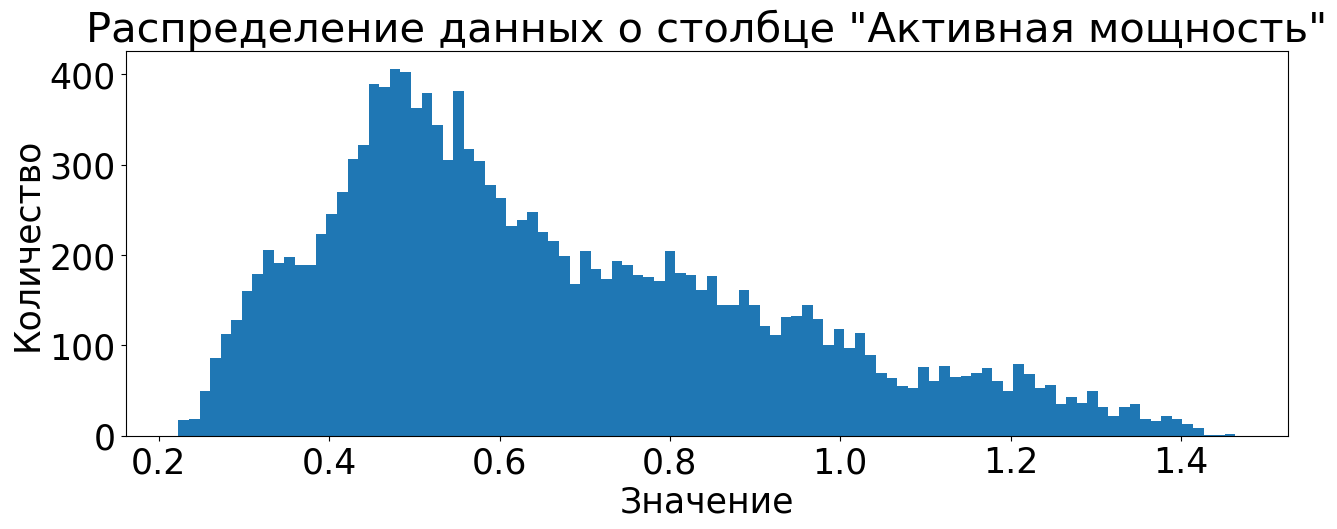

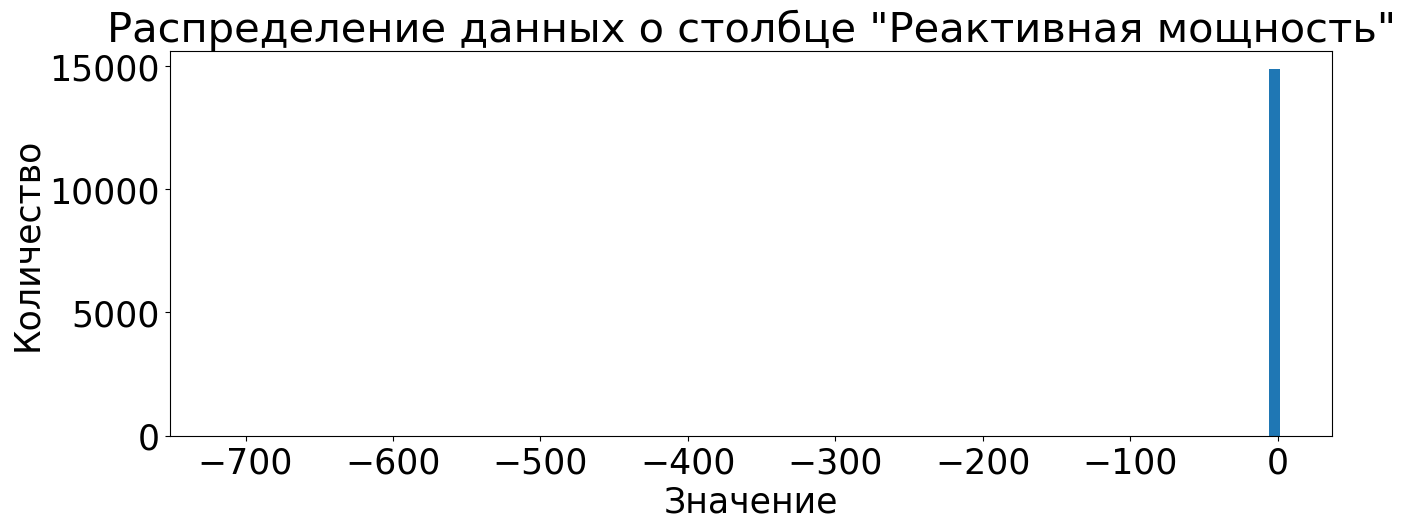

In [120]:
for i in data_arc_new[['Активная мощность', 'Реактивная мощность']]:
    plt.figure(figsize=(15,5))
    data_arc_new[i].plot(kind='hist', bins=100)
    plt.title(f'Распределение данных о столбце "{i}"')
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show()

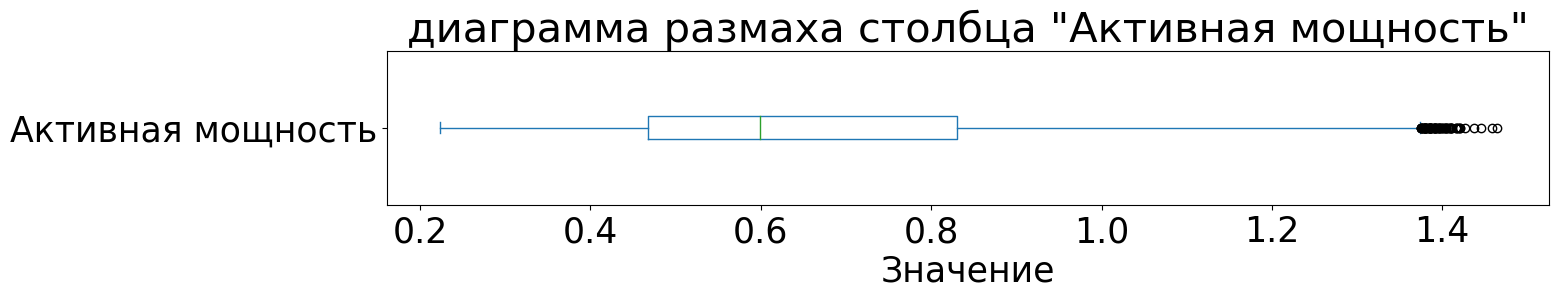

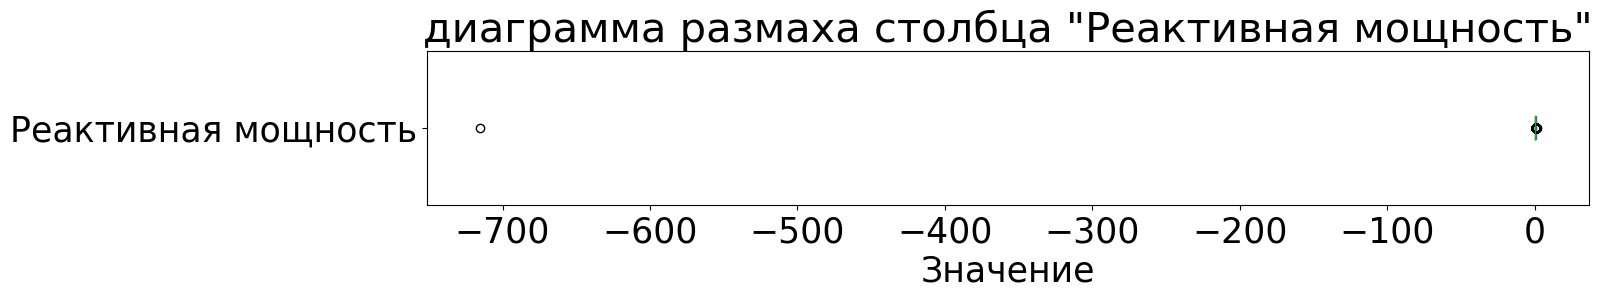

In [121]:
for i in data_arc_new[['Активная мощность', 'Реактивная мощность']]:
    plt.figure(figsize=(15,2))
    data_arc_new[i].plot(kind='box', vert = False)
    plt.title(f'диаграмма размаха столбца "{i}"')
    plt.xlabel('Значение')
    plt.show()

In [122]:
data_arc_new.loc[data_arc_new['Реактивная мощность']<0]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57           0.705344   

      Реактивная мощность  
9780          -715.479924

в реактивной мощности есть выброс. мешает анализировать статистику 

In [123]:
data_arc_new.loc[data_arc_new['Реактивная мощность']>0].corr()

key  Активная мощность  Реактивная мощность
key                  1.000000          -0.010226            -0.013169
Активная мощность   -0.010226           1.000000             0.966373
Реактивная мощность -0.013169           0.966373             1.000000

между столбцами корреляция близкая к 1, то есть можно заполнить аномалию из соседнего столбца

In [124]:
data_arc_new_copy = data_arc_new
data_arc_new_copy.loc[data_arc_new['Реактивная мощность']<0, 'Реактивная мощность'] = data_arc_new_copy.loc[data_arc_new['Реактивная мощность']<0, 'Активная мощность']

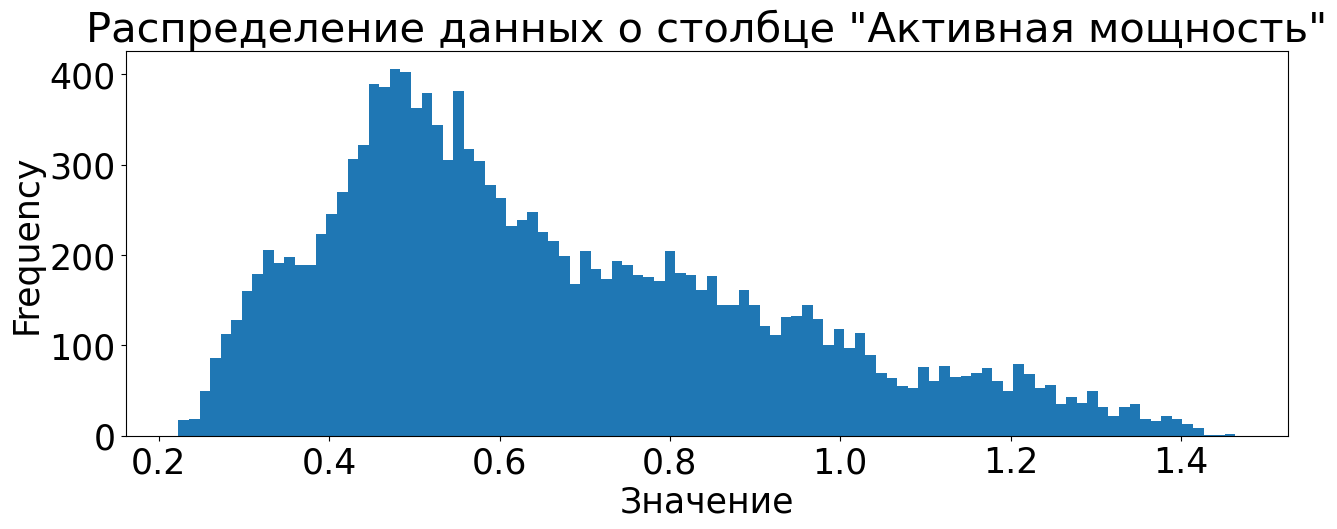

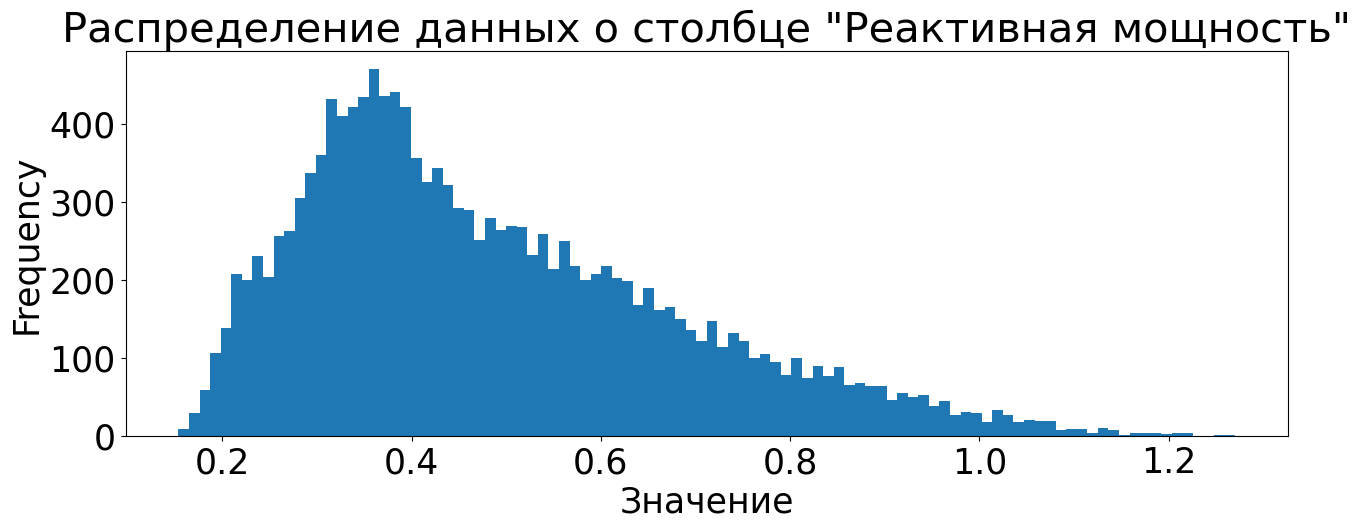

In [125]:
for i in data_arc_new_copy[['Активная мощность', 'Реактивная мощность']]:
    plt.figure(figsize=(15,5))
    data_arc_new_copy[i].plot(kind='hist', bins=100)
    plt.title(f'Распределение данных о столбце "{i}"')
    plt.xlabel('Значение')
    plt.show()

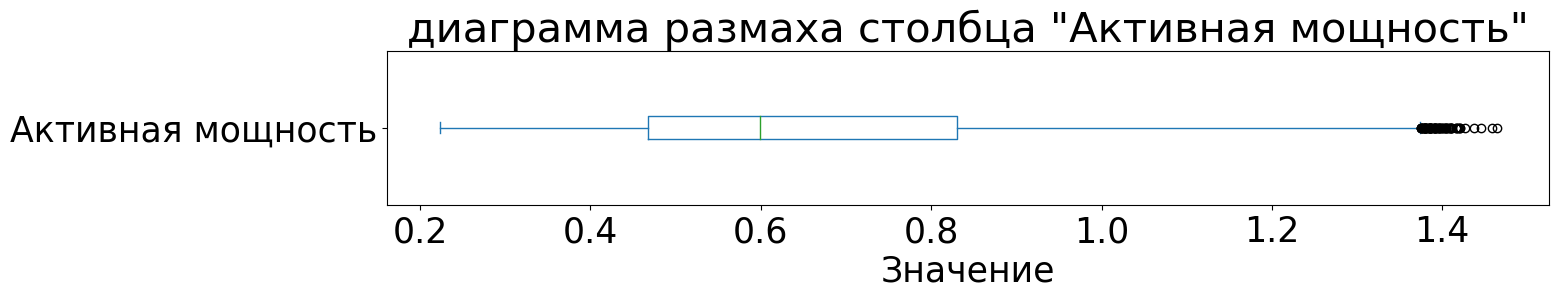

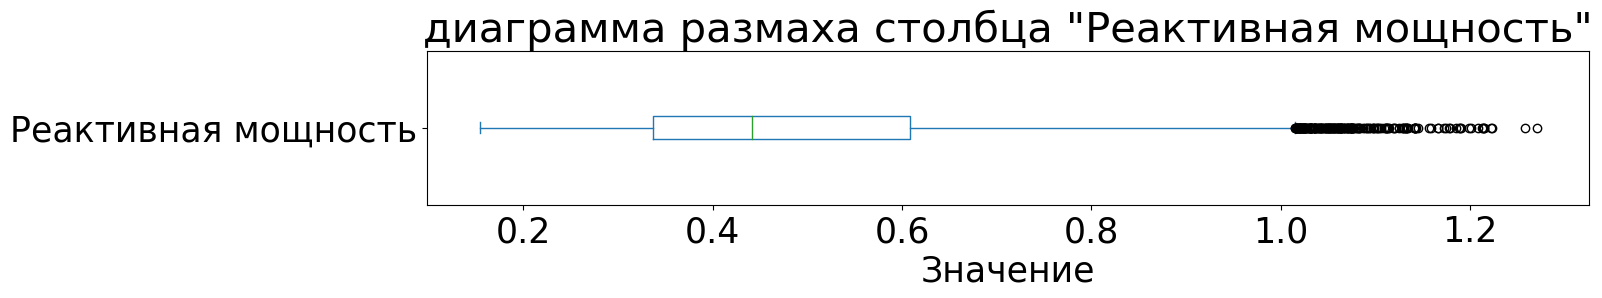

In [126]:
for i in data_arc_new_copy[['Активная мощность', 'Реактивная мощность']]:
    plt.figure(figsize=(15,2))
    data_arc_new_copy[i].plot(kind='box', vert = False)
    plt.title(f'диаграмма размаха столбца "{i}"')
    plt.xlabel('Значение')
    plt.show()

<b>вывод по п. 2.1:</b><br>
были загружены данные, выведена общая информация по датасету об электродах.<br>
пропуски отсутствуют, всего даных 14876. гистограммы распределений похожи, по форме напоминают распределение Пуассона.
диаграмма размаха показывает некоторое количество выбросов (за максимальным НЕвыбросом)

## исследование датафрейма с данными о подаче сыпучих материалов (объём)

In [127]:
print('общая информация данных о подаче сыпучих материалов (объём)')
data_bulk_new = data_load_stat('data_bulk_new')

общая информация данных о подаче сыпучих материалов (объём)
пример данных


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0



общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


статистика распределения


key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000



полные дубли


0



пропуски


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

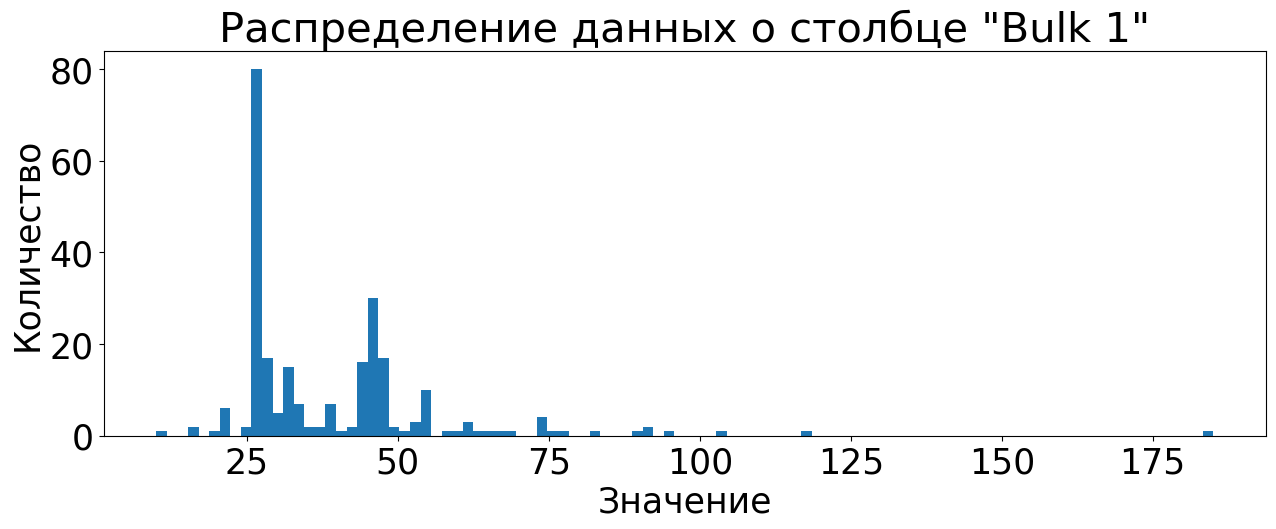

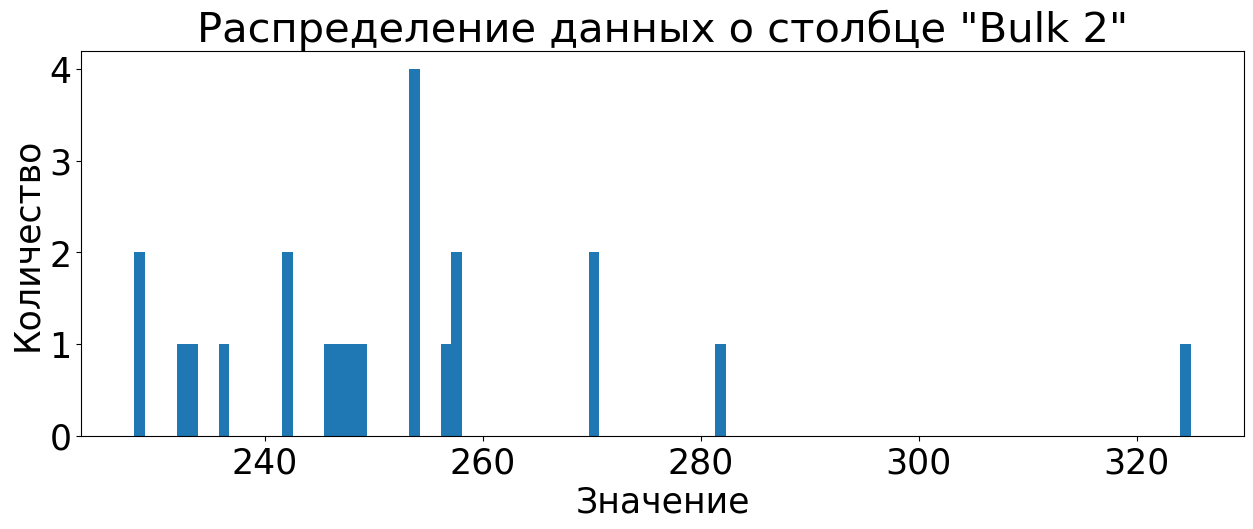

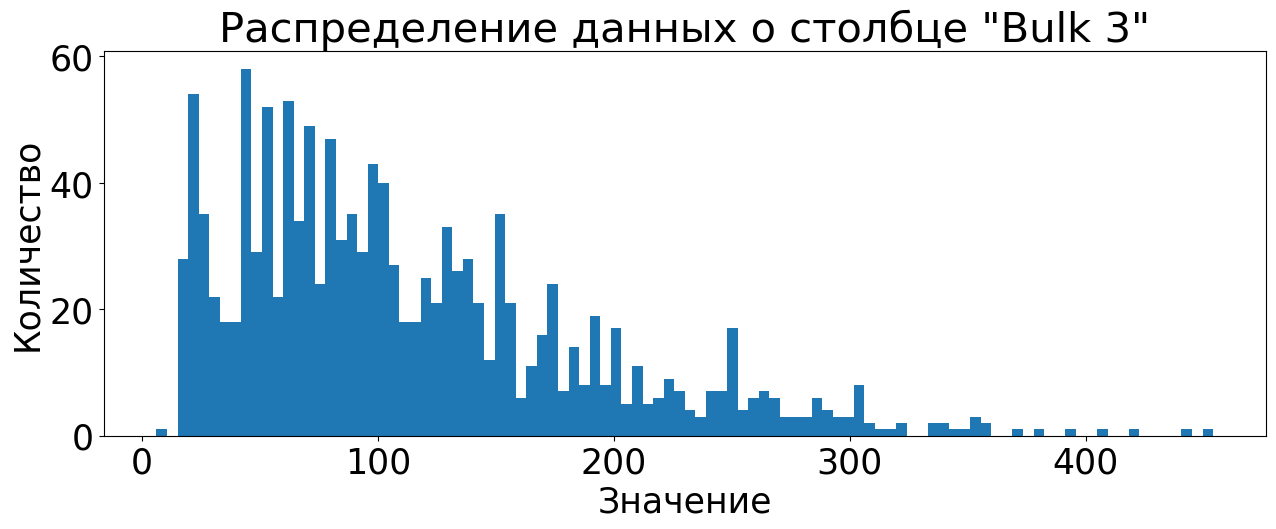

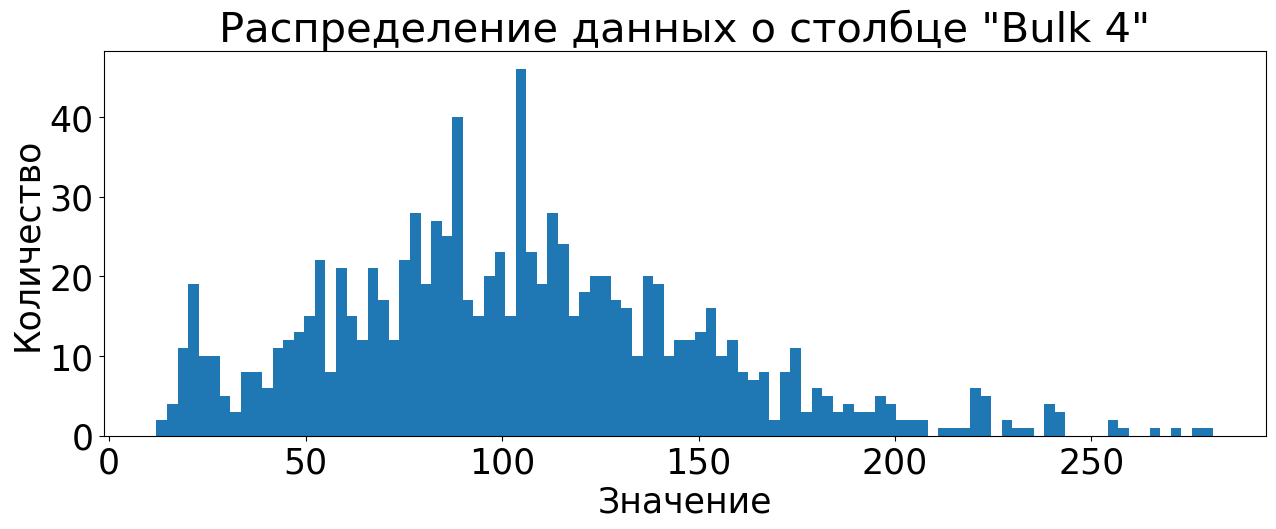

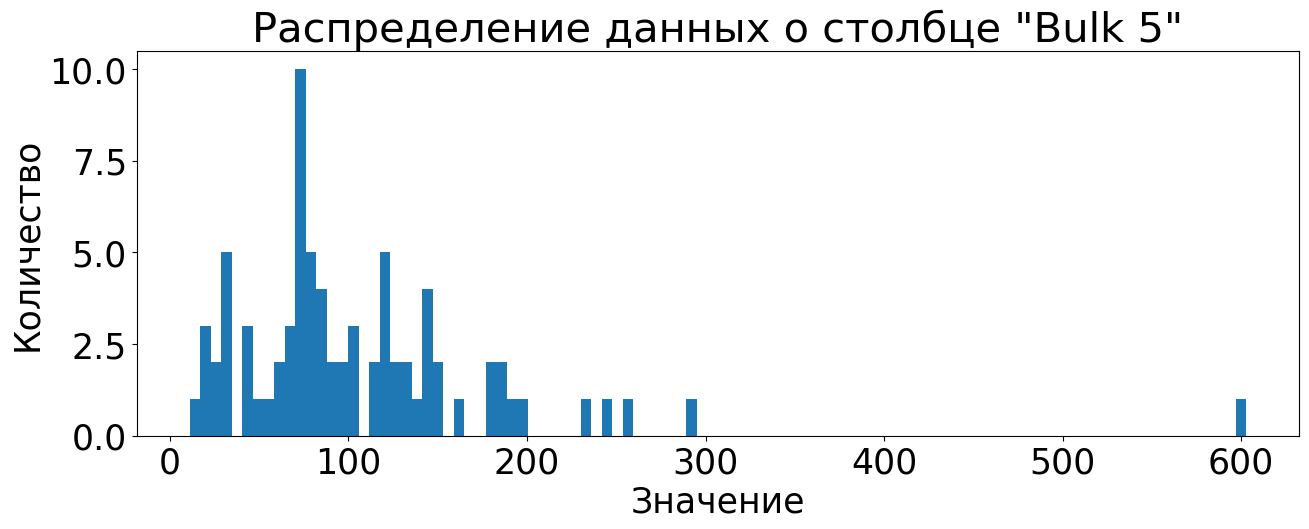

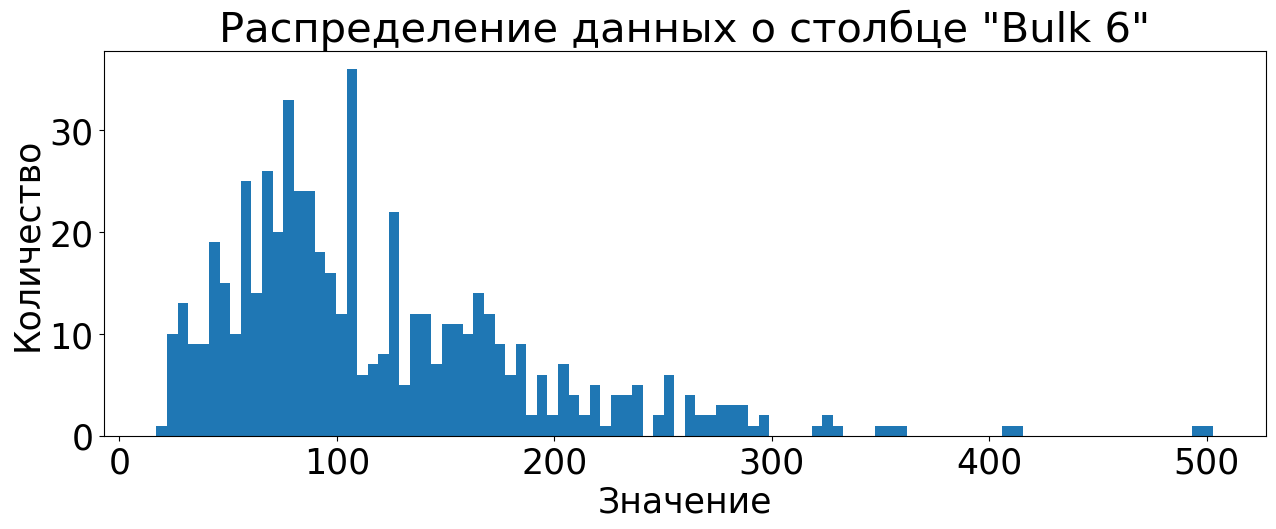

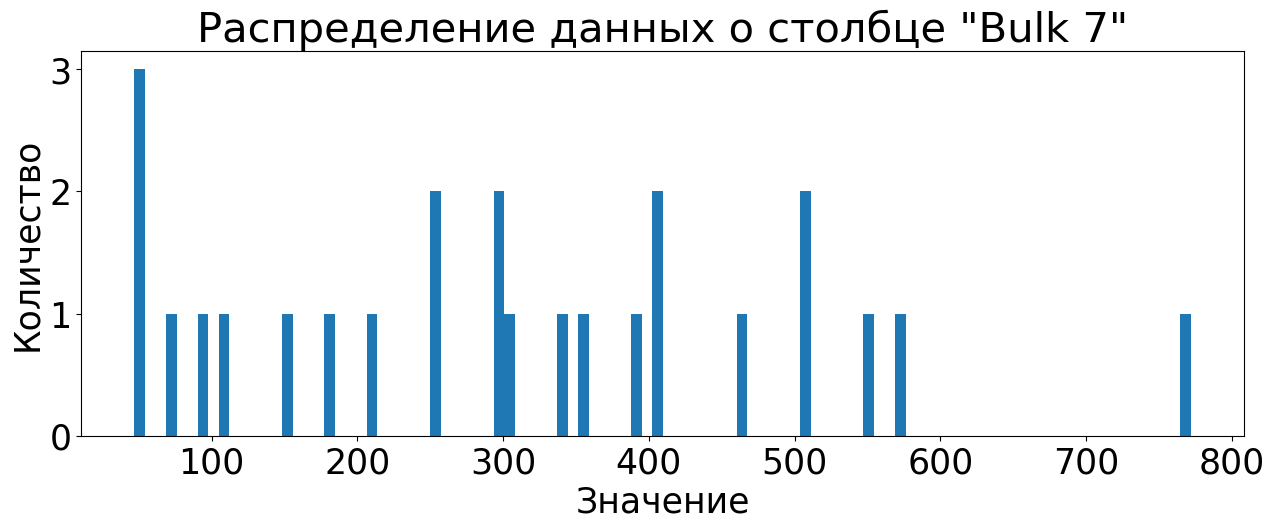

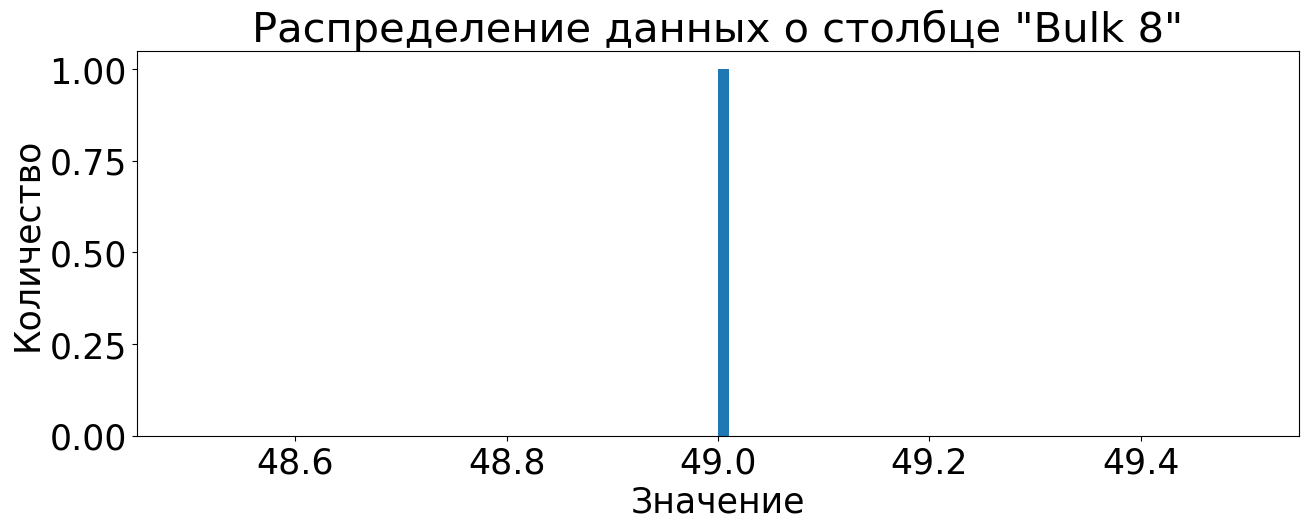

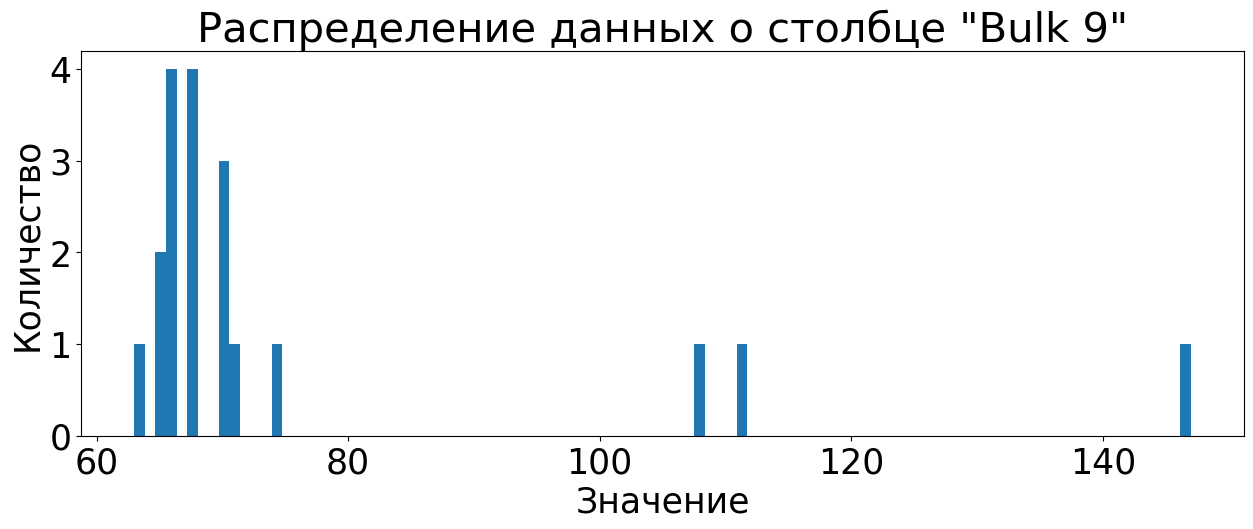

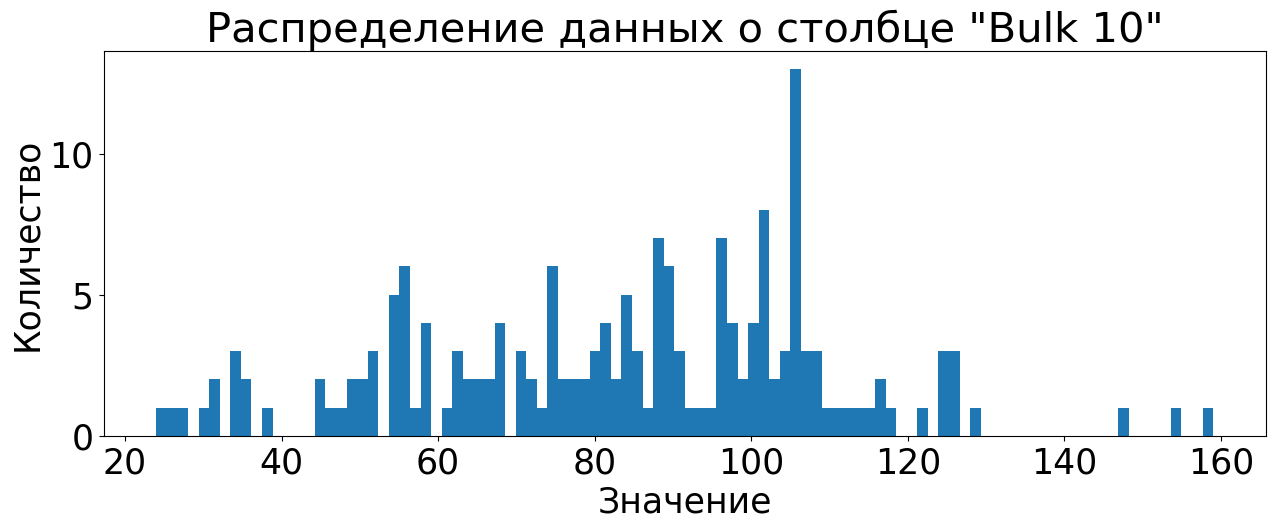

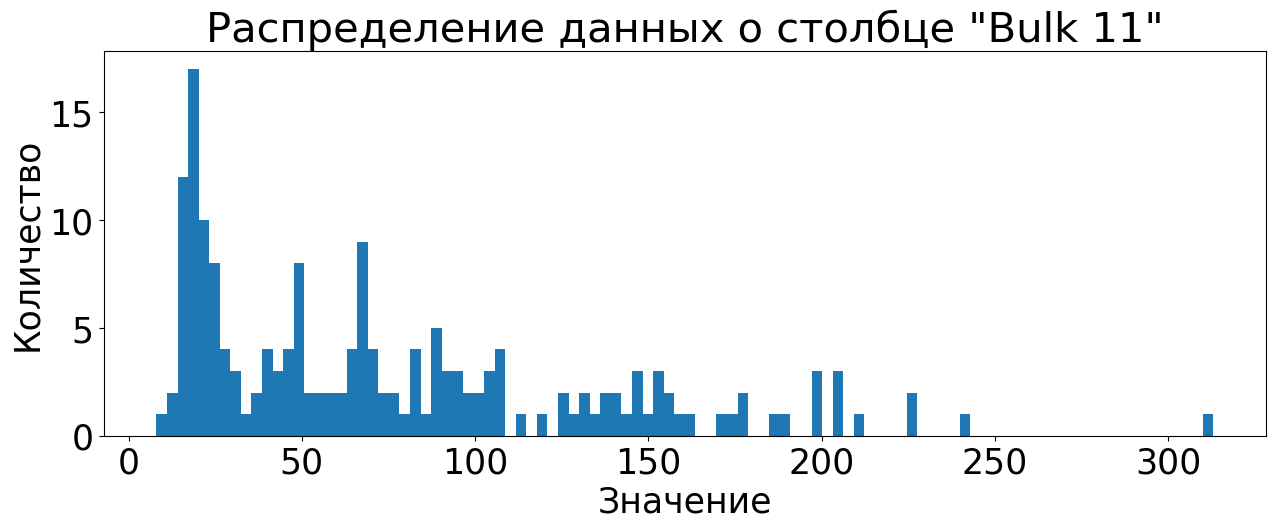

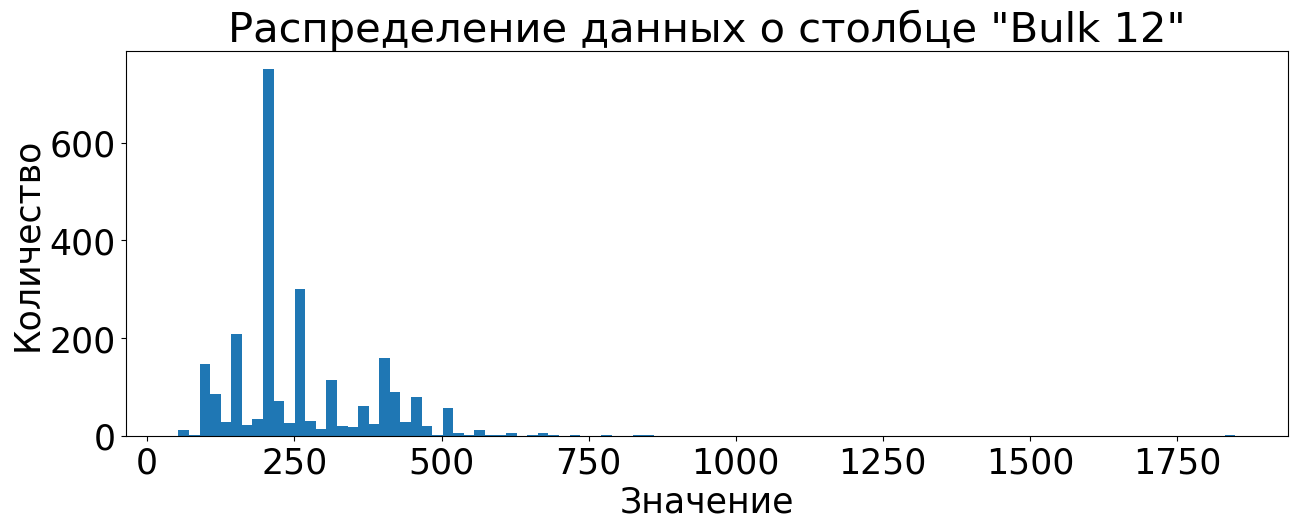

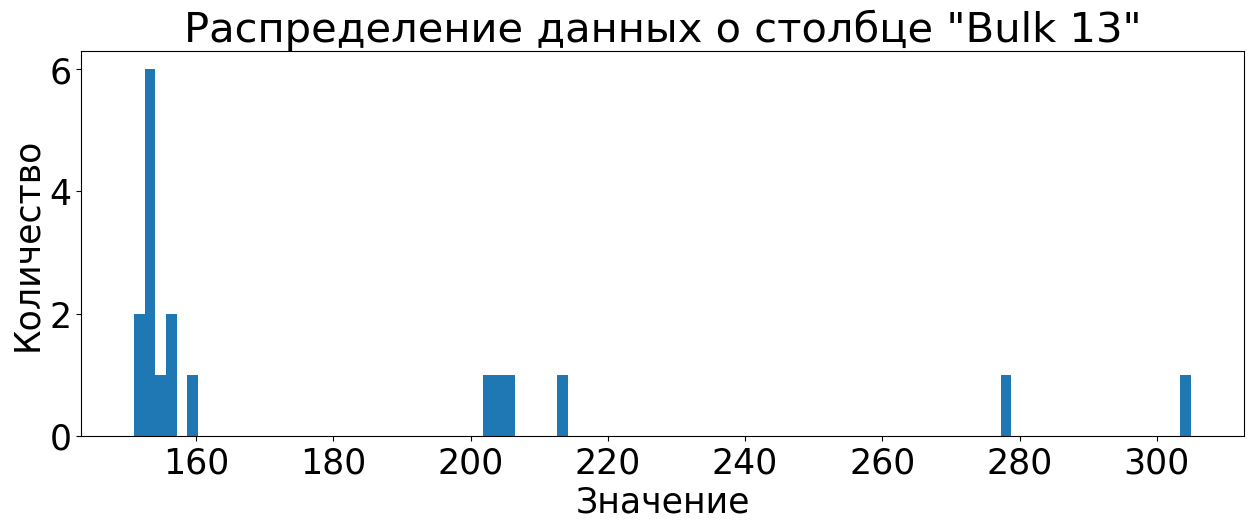

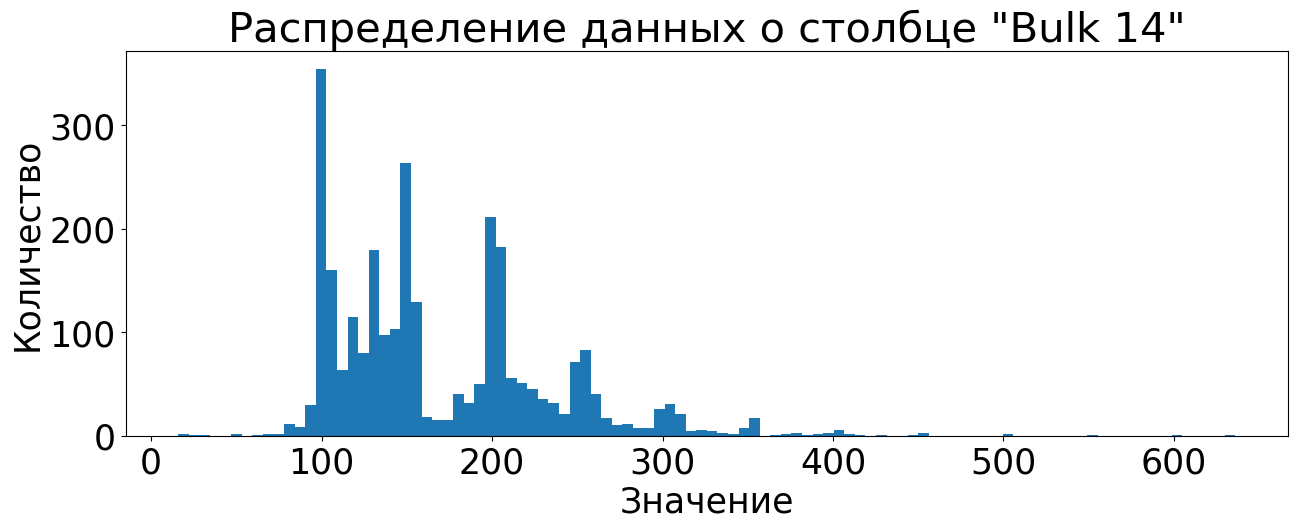

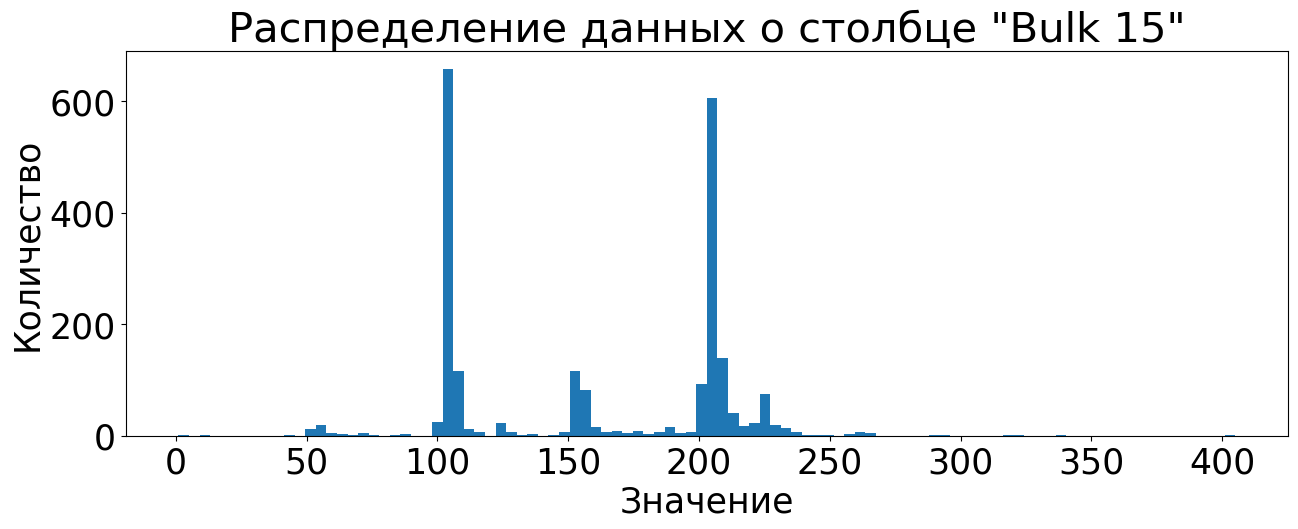

In [128]:
for i in data_bulk_new.drop('key',axis=1):
    plt.figure(figsize=(15,5))
    data_bulk_new[i].plot(kind='hist', bins=100)
    plt.title(f'Распределение данных о столбце "{i}"')
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show()

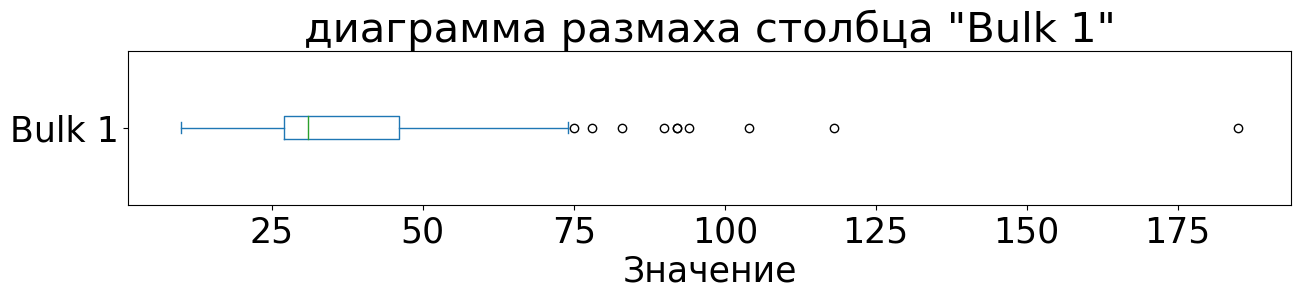

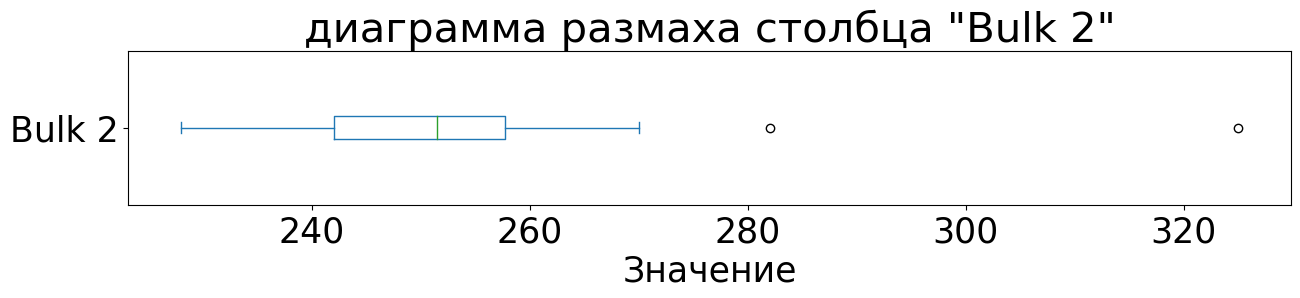

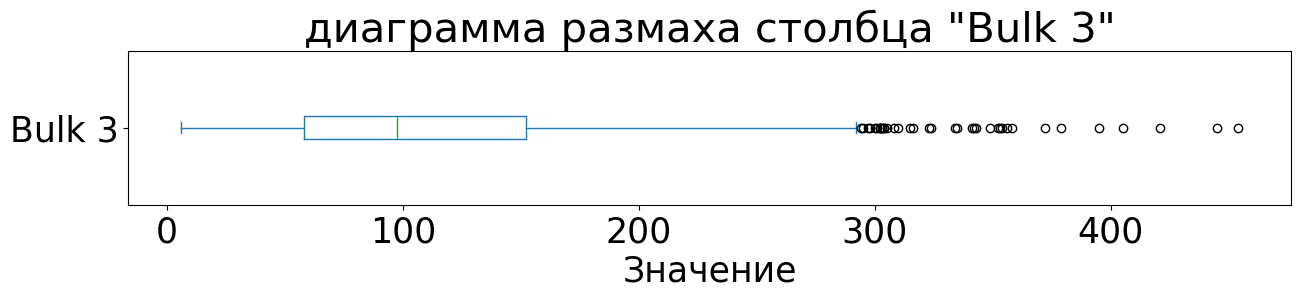

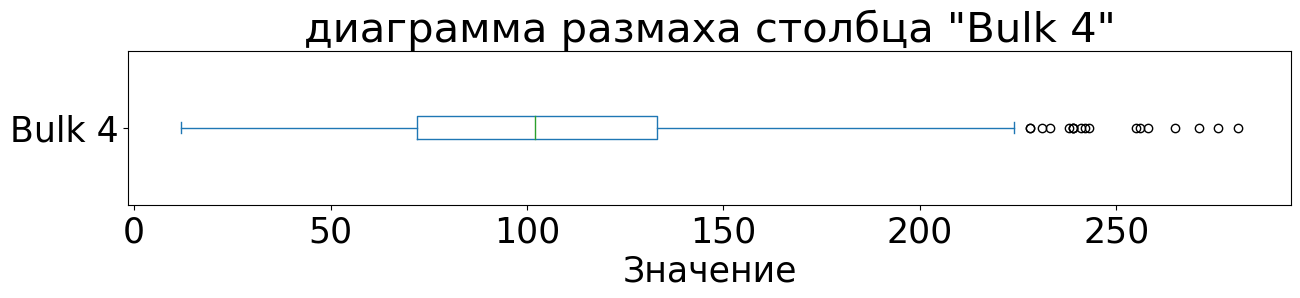

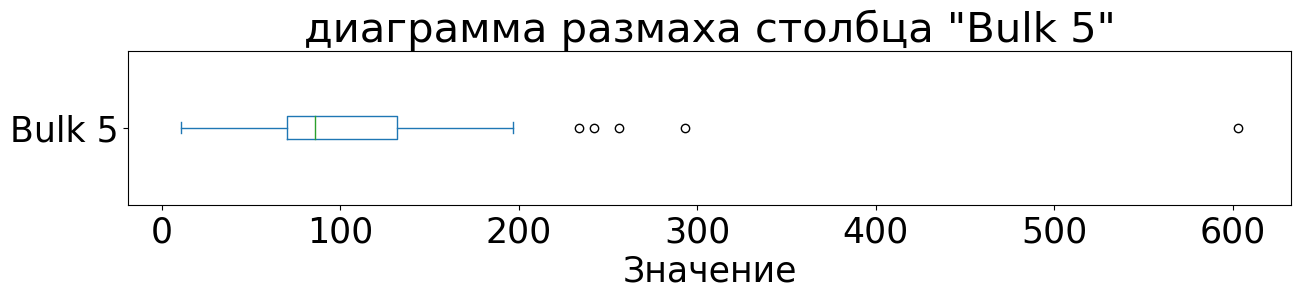

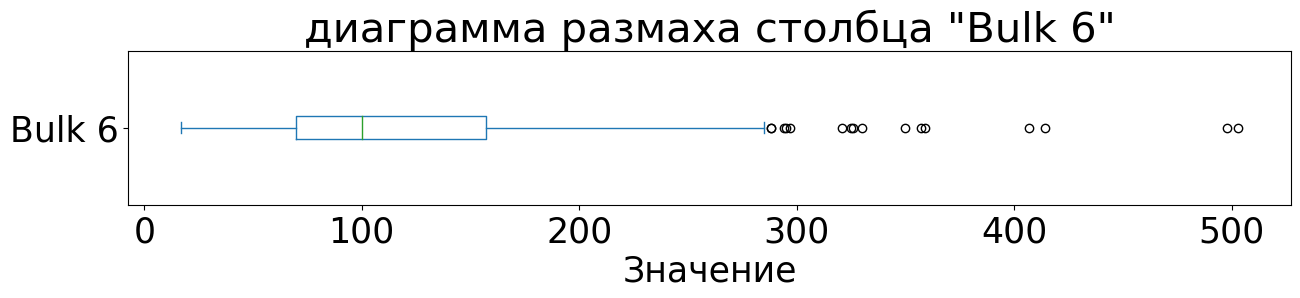

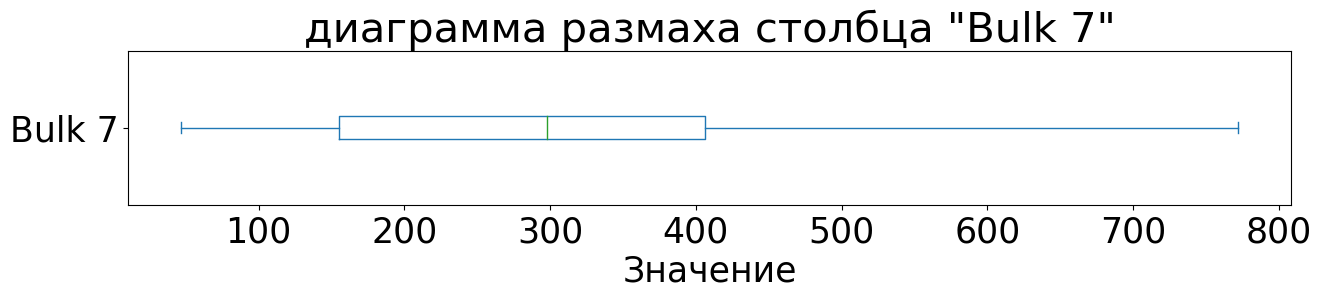

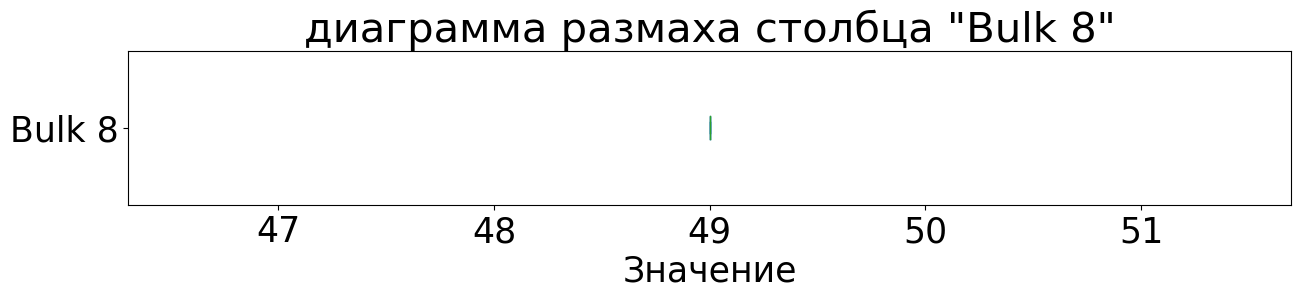

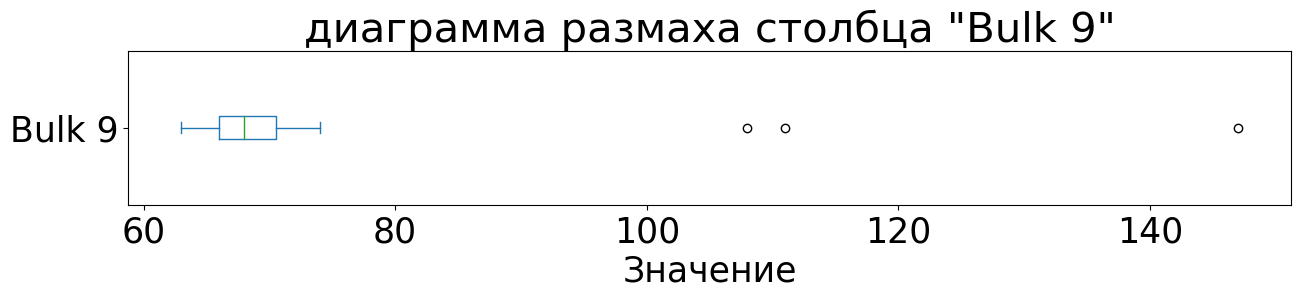

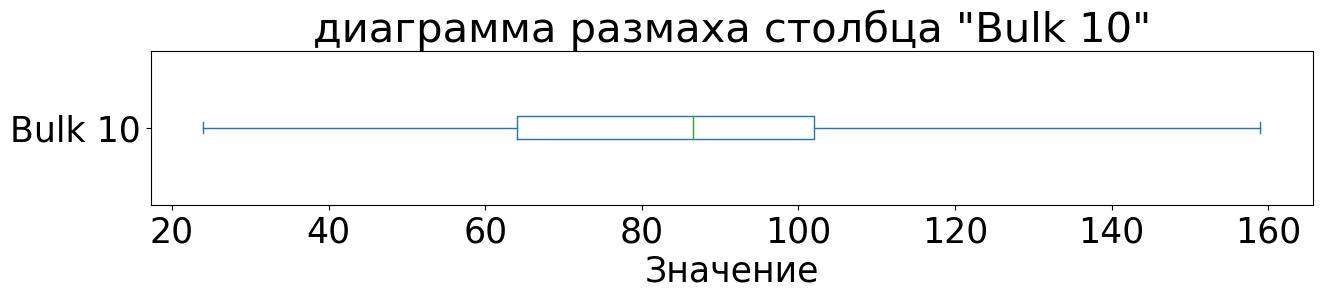

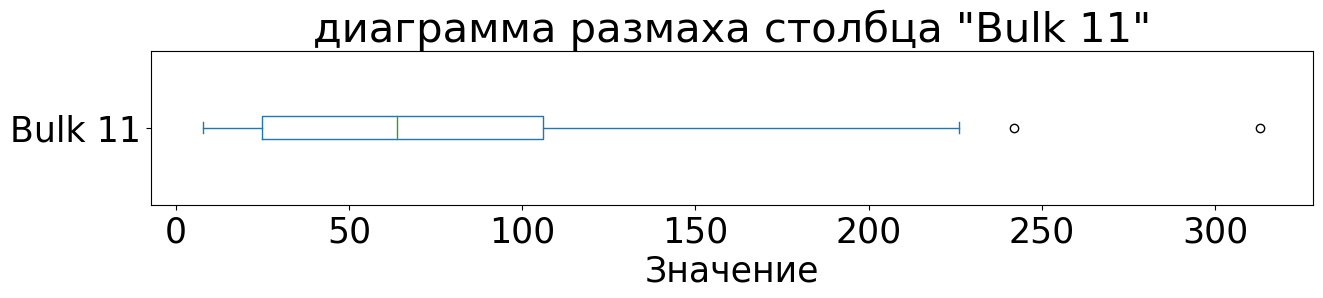

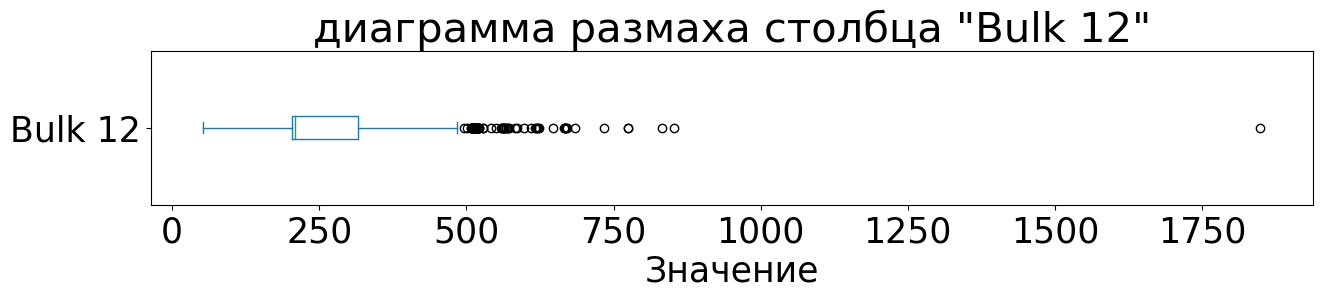

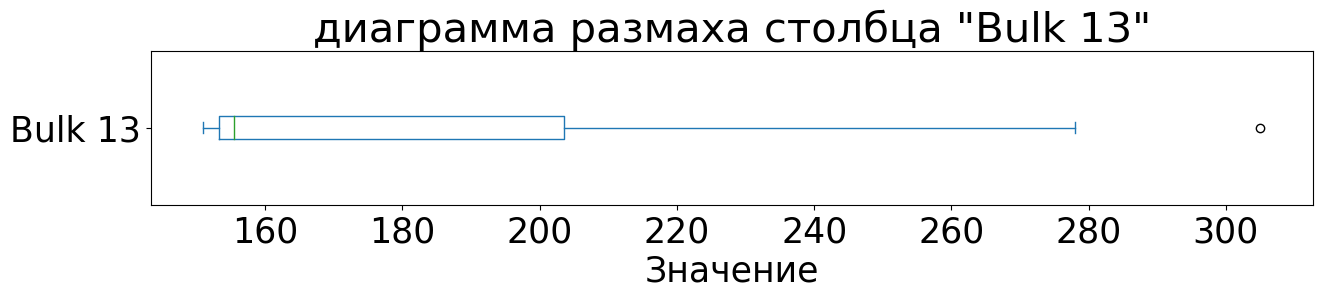

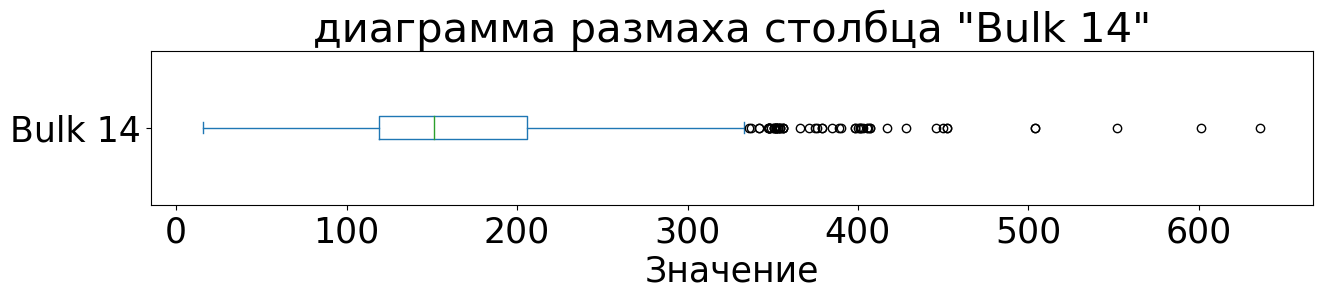

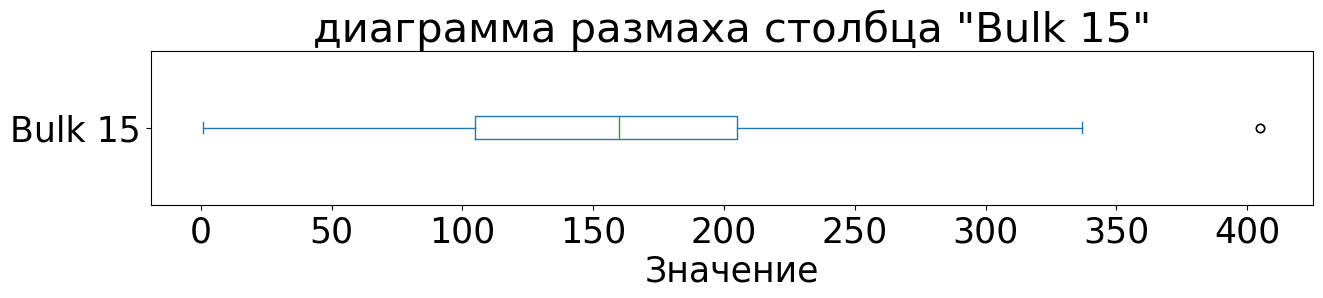

In [129]:
for i in data_bulk_new.drop('key',axis=1):
    plt.figure(figsize=(15,2))
    data_bulk_new[i].plot(kind='box', vert = False)
    plt.title(f'диаграмма размаха столбца "{i}"')
    plt.xlabel('Значение')
    plt.show()

<b>вывод по п. 2.2:</b><br>
были загружены данные, выведена общая информация по датасету о подаче сыпучих материалов (объём)<br>
всего данных 3129. пропусков много, почти по всем столбцам кроме key (что логично). кроме этого близко к 10% пропусков у столбца Bulk 14, в остальных столбцах в разы больше. распределения разные абсолютно, есть похожие на нормальное (например Bulk 4), есть похожие на Пуассона (например Bulk 6).
диаграмма размаха показывает некоторое количество выбросов (опять же за максимальным НЕвыбросом) почти во всех столбцах (кроме Bulk 8 и Bulk 10).

## исследование датафрейма с данными о подаче сыпучих материалов (время)

In [130]:
print('общая информация данных о подаче сыпучих материалов (время)')
data_bulk_time_new = data_load_stat('data_bulk_time_new')

общая информация данных о подаче сыпучих материалов (время)
пример данных


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39



общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


статистика распределения


key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000



полные дубли


0



пропуски


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

<b>вывод по п. 2.3:</b><br>
были загружены данные, выведена общая информация по датасету о подаче сыпучих материалов (время)<br>
всего данных 3129. пропусков так же много, меньше всего опять же у столбца Bulk 14. количество пропусков совпадает с пропусками предыдущего датасета (допускаю что проблема не в выгрузке данных. либо ошибались при сборе данных, либо ошибок нет и процесс технологически именно так и должен был выглядеть).

## исследование датафрейма с данными о продувке сплава газом

In [131]:
print('общая информация данных о продувке сплава газом')
data_gas_new = data_load_stat('data_gas_new')

общая информация данных о продувке сплава газом
пример данных


key      Газ 1
0    1  29.749986
1    2  12.555561



общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


статистика распределения


key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040



полные дубли


0



пропуски


key      0
Газ 1    0
dtype: int64

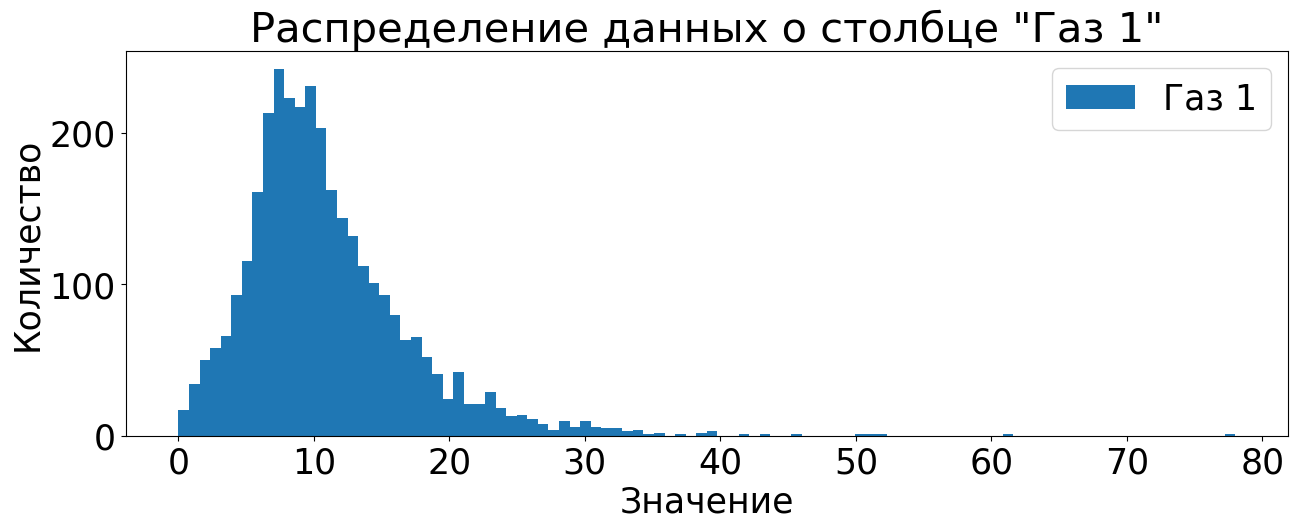

In [132]:
data_gas_new.drop('key',axis=1).plot(kind='hist', bins=100, figsize=(15,5))
plt.title(f'Распределение данных о столбце "Газ 1"')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show();

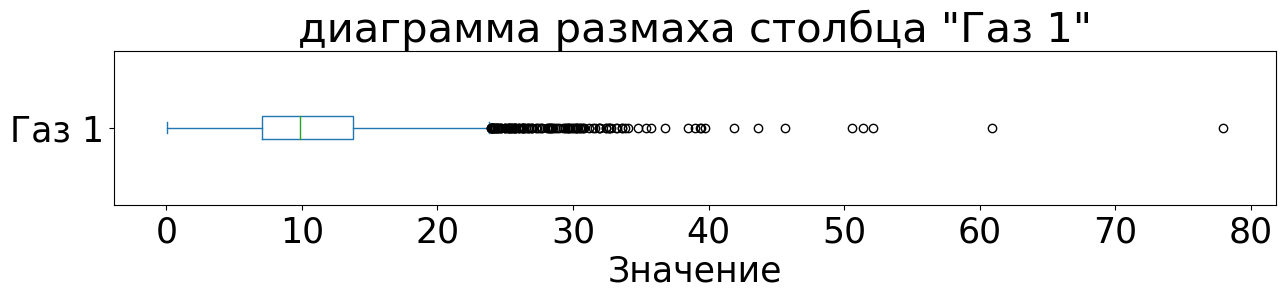

In [133]:
data_gas_new.drop('key',axis=1).plot(kind='box', vert = False, figsize=(15,2))
plt.title(f'диаграмма размаха столбца "Газ 1"')
plt.xlabel('Значение')
plt.show()

<b>вывод по п. 2.4:</b><br>
были загружены данные, выведена общая информация по датасету о продувке сплава газом<br>
количество данных 3239. пропусков нет. распределение близко к Пуассону. диаграма размаха показывает выбросы за максимумом.

## исследование датафрейма с данными об измерении температуры

In [134]:
print('общая информация результатов измерения температуры')
data_temp_new = data_load_stat('data_temp_new')

общая информация результатов измерения температуры
пример данных


key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0



общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


статистика распределения


key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000



полные дубли


0



пропуски


key                0
Время замера       0
Температура     3427
dtype: int64

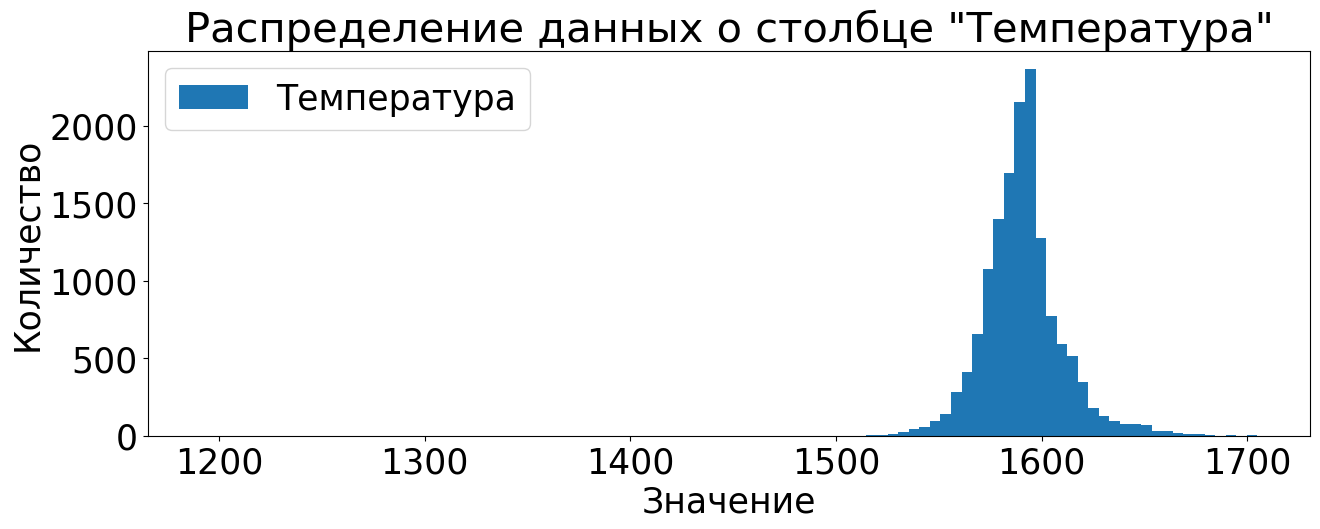

In [135]:
data_temp_new.drop(['key','Время замера'], axis=1).plot(kind='hist', bins=100, figsize=(15,5))
plt.title('Распределение данных о столбце "Температура"')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

<Figure size 1500x200 with 0 Axes>

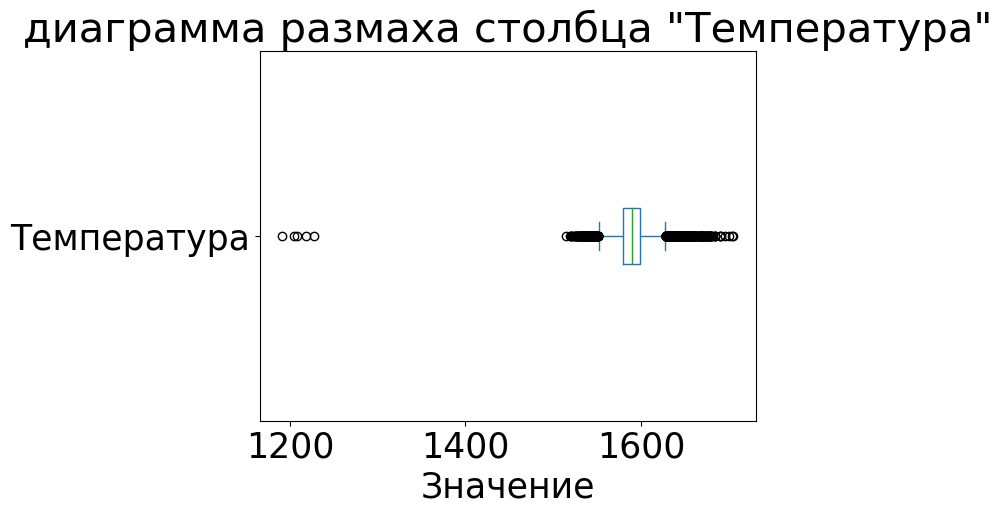

In [136]:
plt.figure(figsize=(15,2))
data_temp_new.drop(['key','Время замера'], axis=1).plot(kind='box', vert = False)
plt.title(f'диаграмма размаха столбца "Температура"')
plt.xlabel('Значение')
plt.show()

<b>вывод по п. 2.5:</b><br>
были загружены данные, выведена общая информация по датасету об измерении темпеатуры<br>
количество данных 18092. пропусков ~18% в столбце температуры. распределение близко к номальному. диаграмма размаха показывает выбросы с обеих сторон.

## исследование датафрейма с данными о проволочных материалах (объём)

In [137]:
print('общая информация данных о проволочных материалах (объём)')
data_wire_new = data_load_stat('data_wire_new')

общая информация данных о проволочных материалах (объём)
пример данных


key     Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN



общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


статистика распределения


key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442842  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604



полные дубли


0



пропуски


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

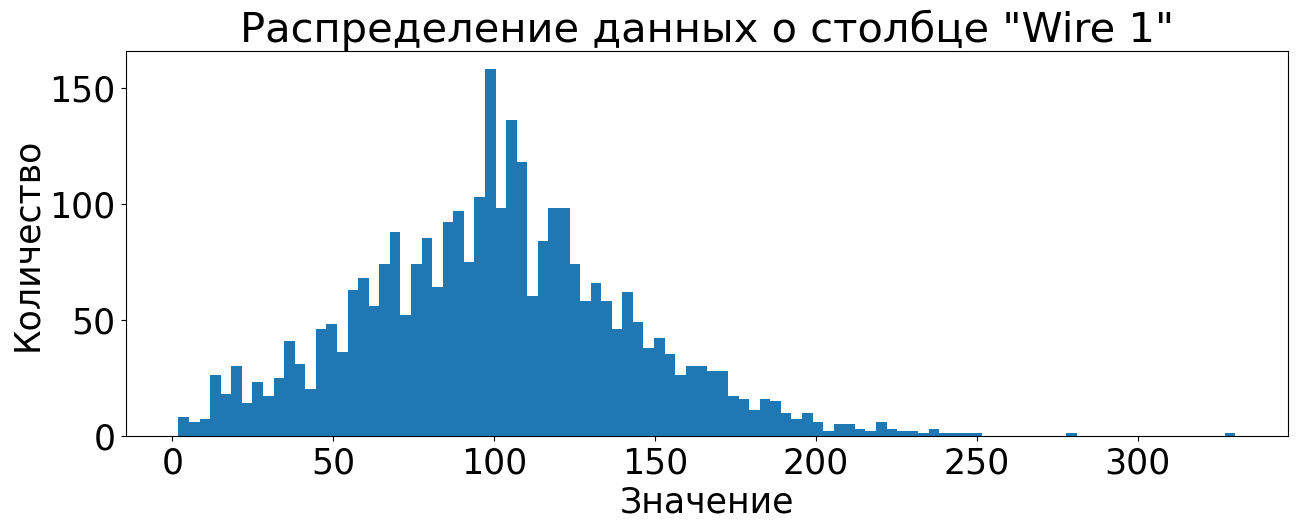

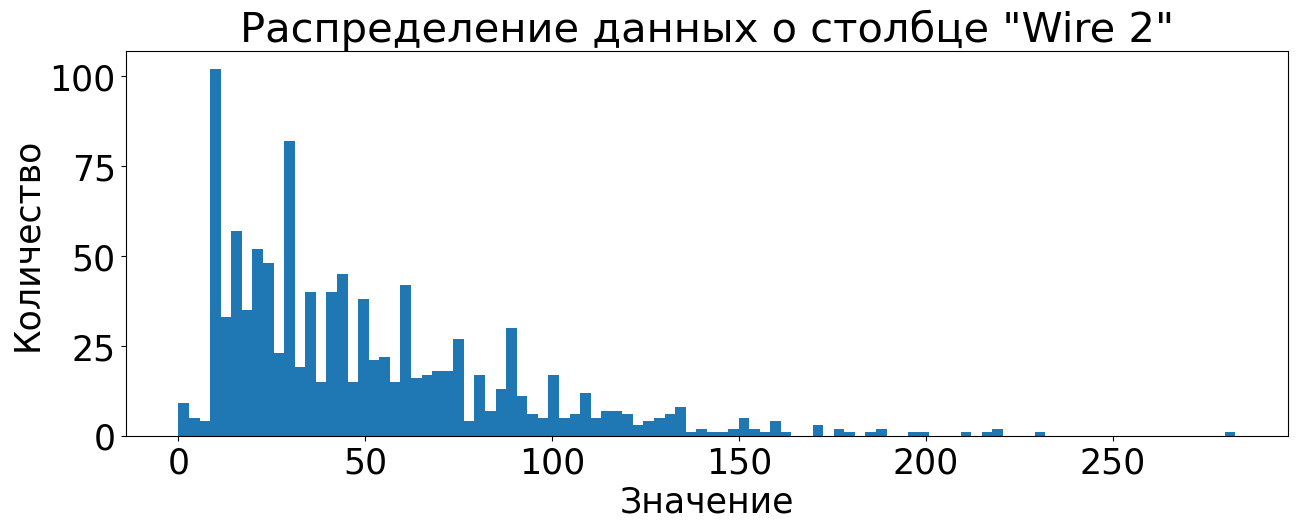

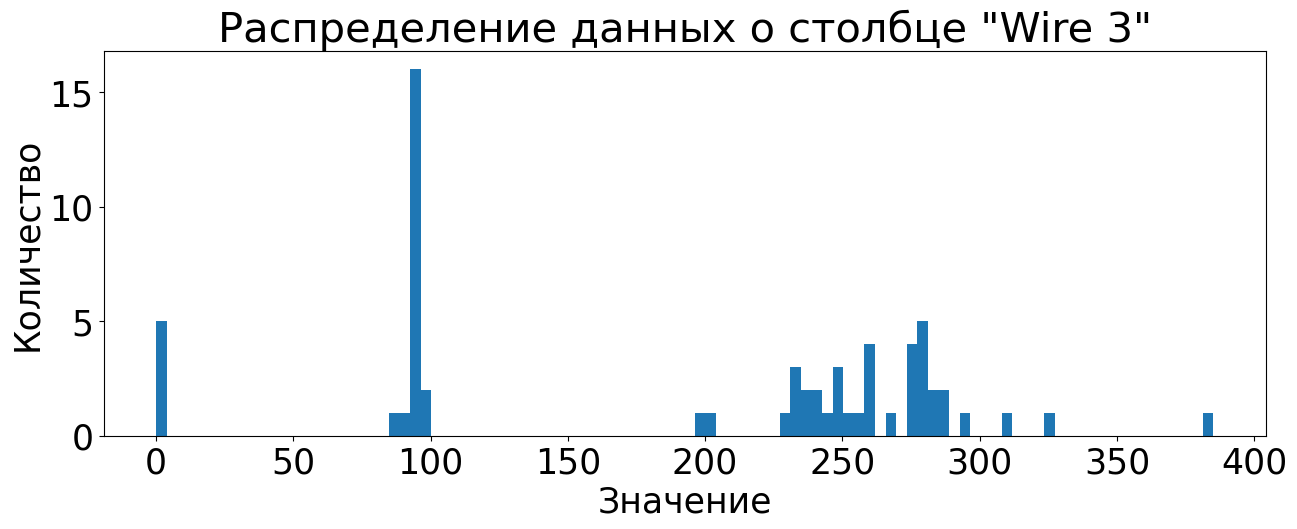

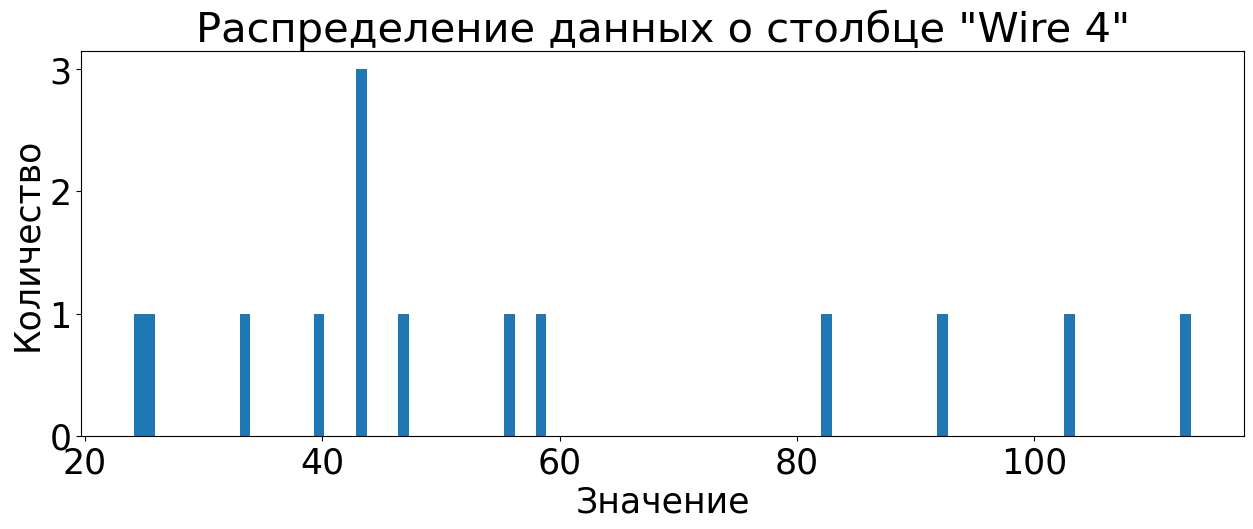

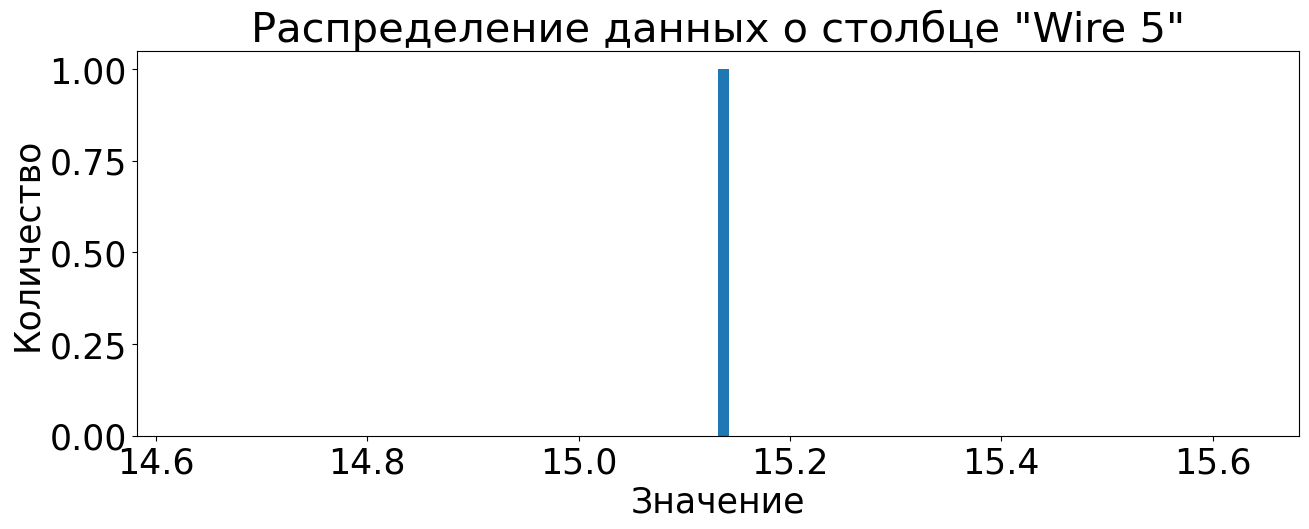

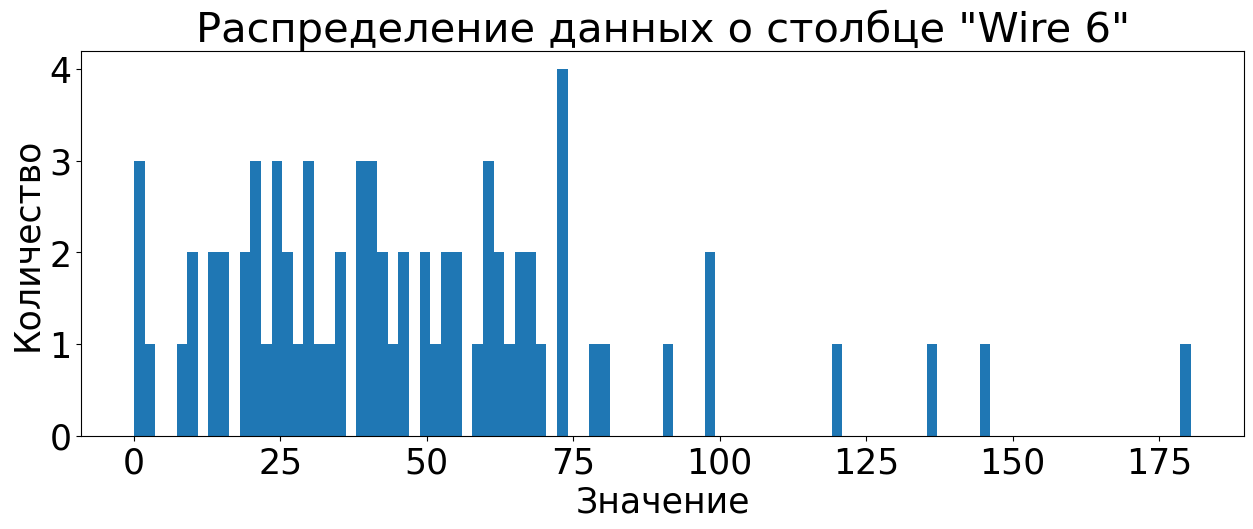

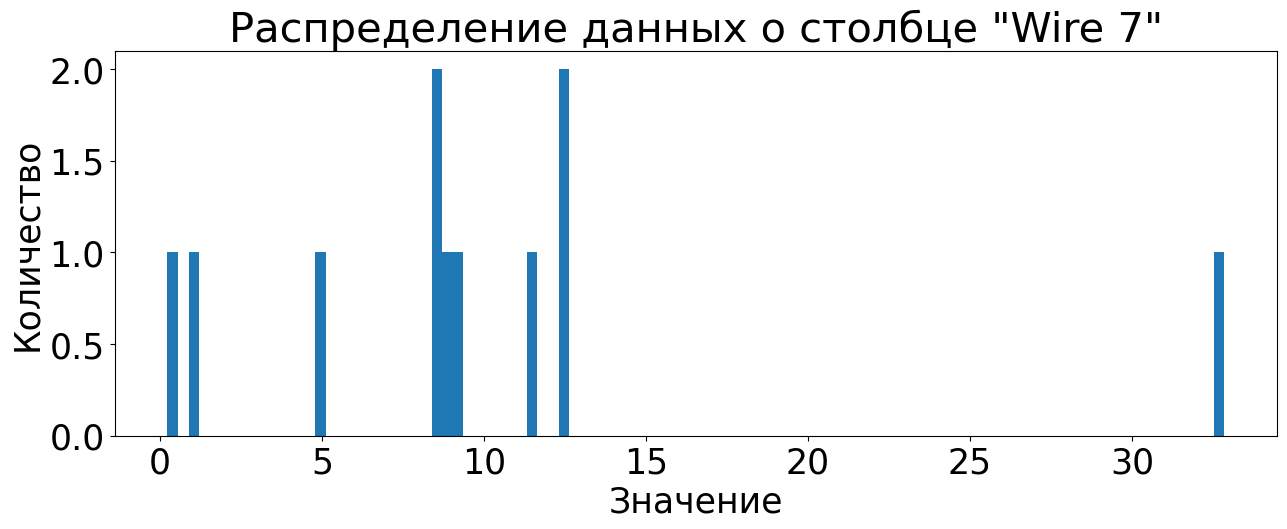

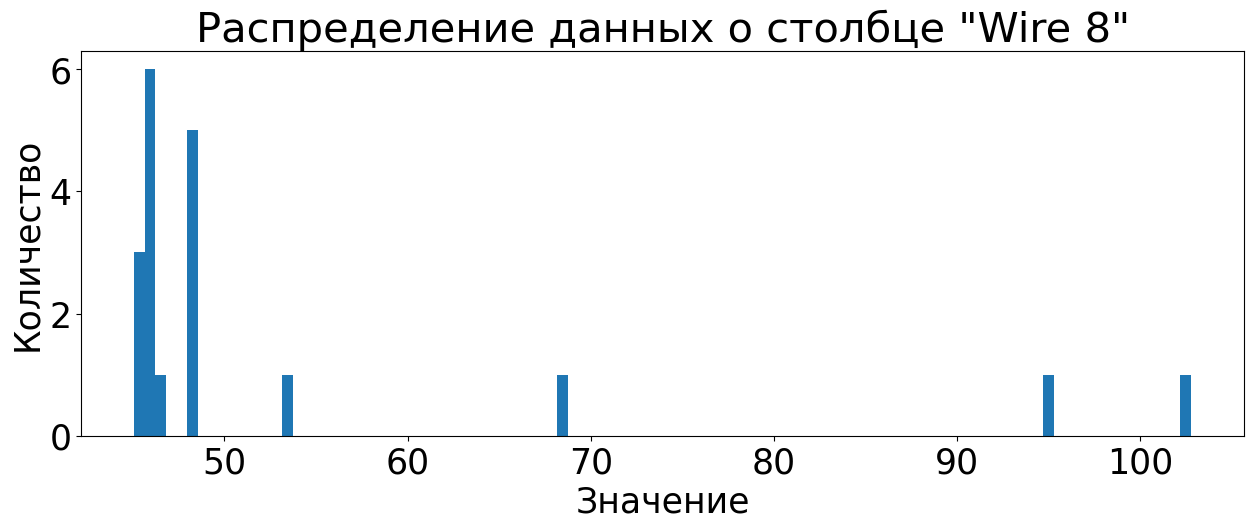

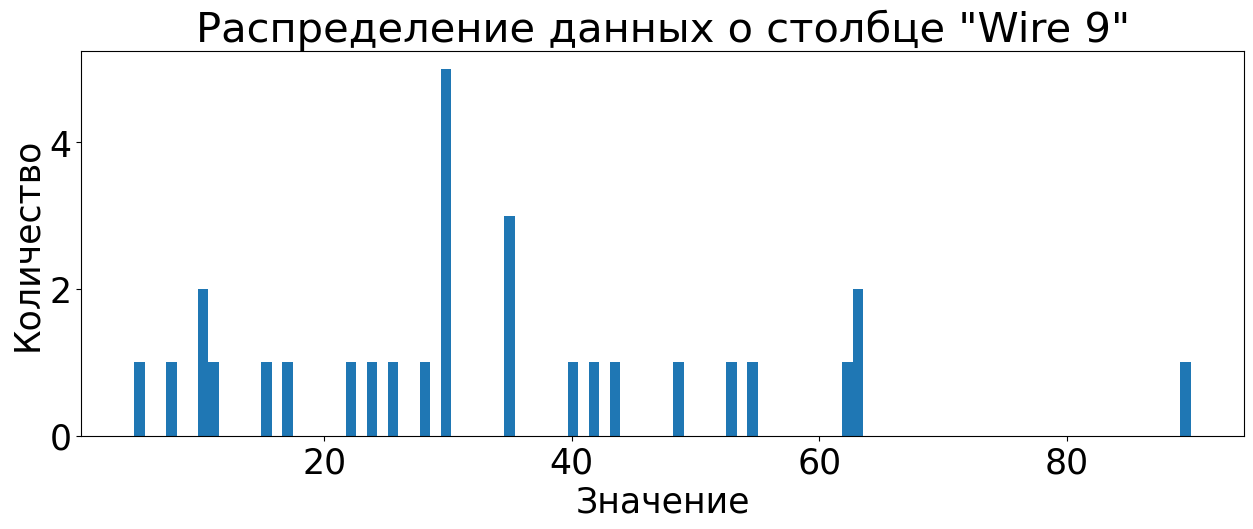

In [138]:
for i in data_wire_new.drop('key',axis=1):
    plt.figure(figsize=(15,5))
    data_wire_new[i].plot(kind='hist', bins=100)
    plt.title(f'Распределение данных о столбце "{i}"')
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show()

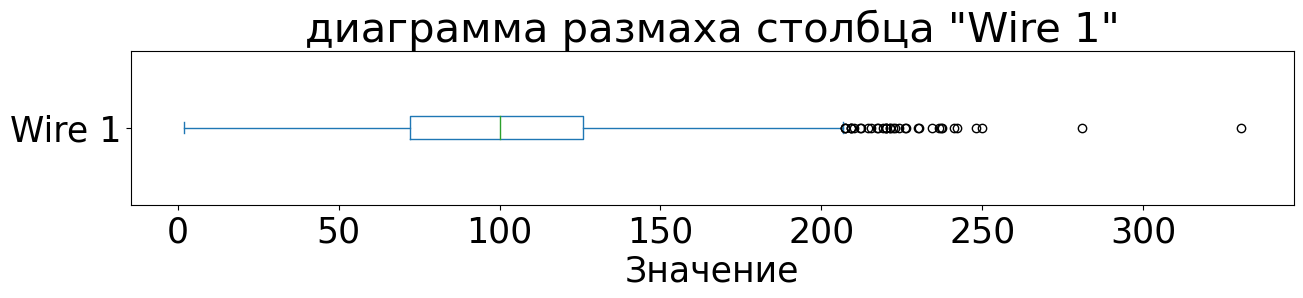

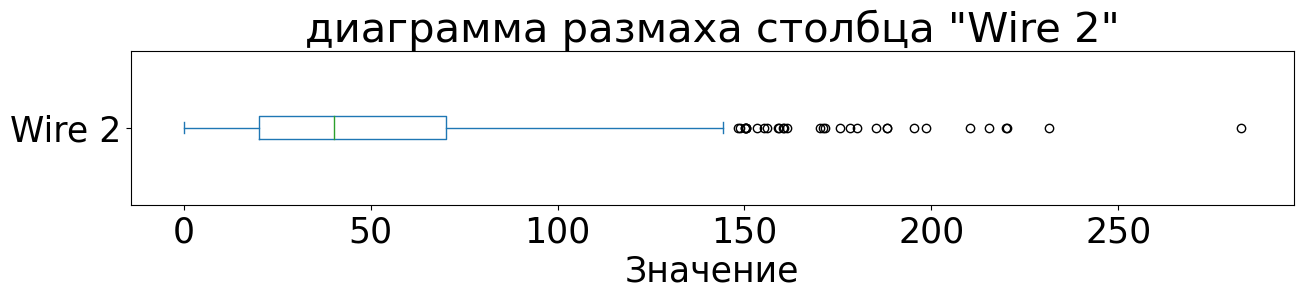

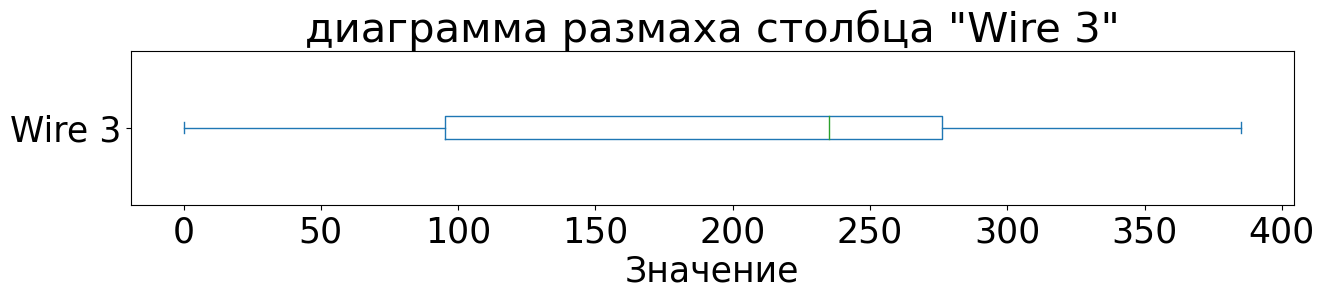

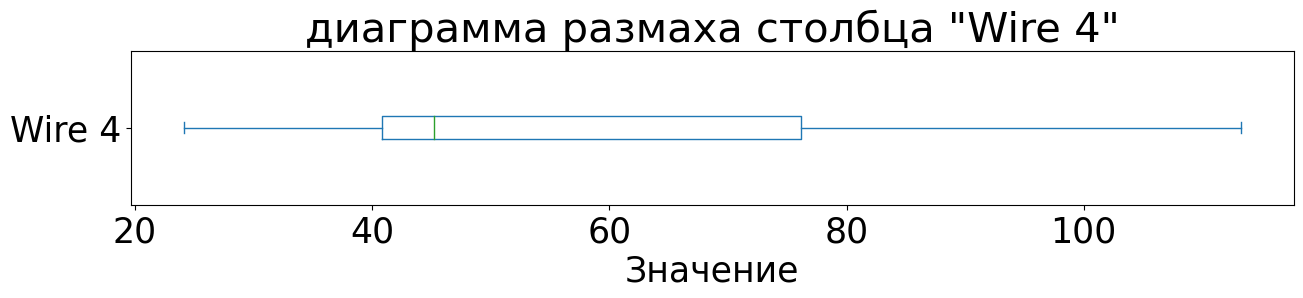

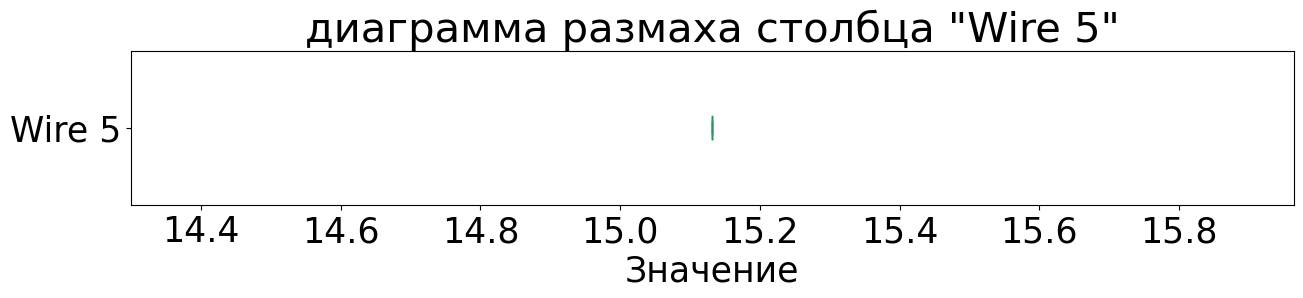

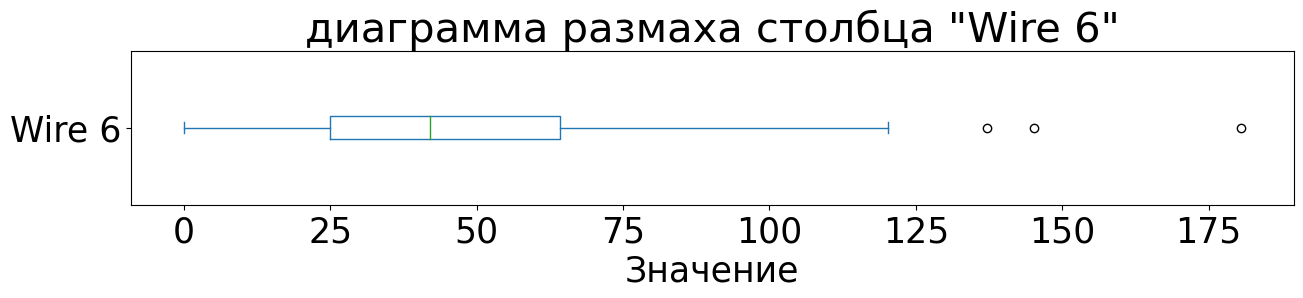

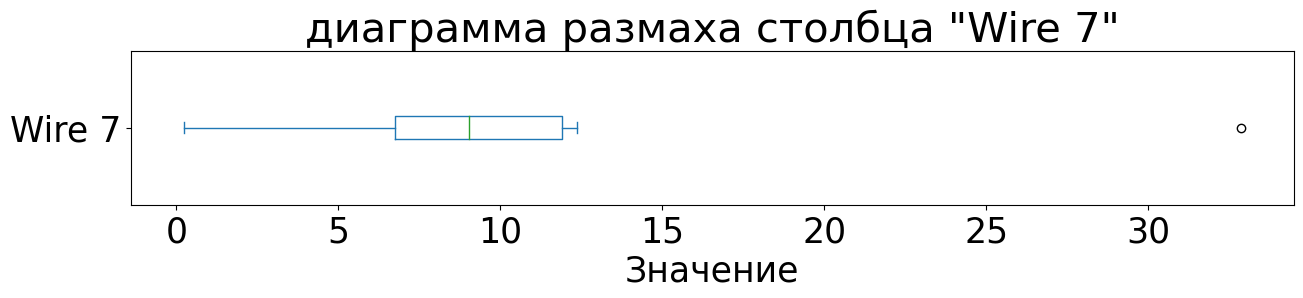

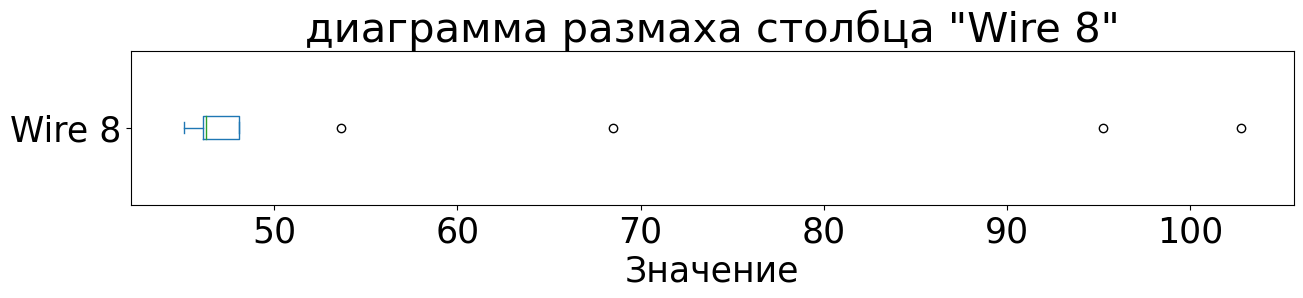

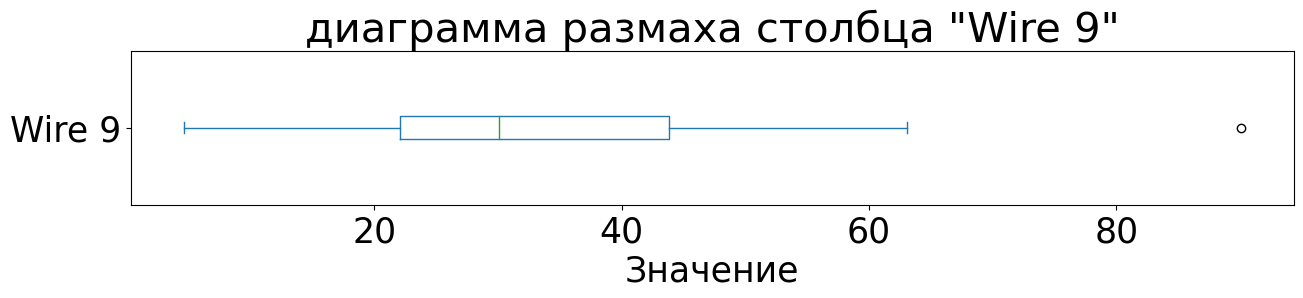

In [139]:
for i in data_wire_new.drop('key',axis=1):
    plt.figure(figsize=(15,2))
    data_wire_new[i].plot(kind='box', vert = False)
    plt.title(f'диаграмма размаха столбца "{i}"')
    plt.xlabel('Значение')
    plt.show()

<b>вывод по п. 2.6:</b><br>
были загружены данные, выведена общая информация по датасету о проволочных материалах (объём)<br>
количество данных 3081. пропусков крайне много почти везде, кроме столбца Wire 1. его распределение похоже на нормальное, Wire 
2 напоминает Пуассона. у остальных затрудняюсь. выбросов нет у Wire 3, 4, 5


## исследование датафрейма с данными о проволочных материалах (время)

In [140]:
print('общая информация данных о проволочных материалах (время)')
data_wire_time_new = data_load_stat('data_wire_time_new')

общая информация данных о проволочных материалах (время)
пример данных


key               Wire 1 Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8  \
0    1  2019-05-03 11:06:19    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

  Wire 9  
0    NaN  
1    NaN



общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


статистика распределения


key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000



полные дубли


0



пропуски


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

<b>вывод по п. 2.7:</b><br>
были загружены данные, выведена общая информация по датасету о проволочных материалах (время).<br>
количество данных 3081. пропуски повторяют предыдущий датасет (как минимум по количеству. допускаю что повторяются 100%)

<b>вопросы заказчику</b><br>
вопрос один- скоррелированы ли столбцы активной и реактивной мощности в данных об электродах? допустимо ли заменять пропуски и аномалии в этих столбцах из соседнего столбца?

# предобработка данных

## изменение типов данных

самое первое- привести даты к своему типу

In [141]:
data_arc_new['Начало нагрева дугой'] = pd.to_datetime(data_arc_new['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc_new['Конец нагрева дугой'] = pd.to_datetime(data_arc_new['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_temp_new['Время замера'] = pd.to_datetime(data_temp_new['Время замера'], format='%Y-%m-%d %H:%M:%S')

data_bulk_time_new и data_wire_time_new использовать не буду, т.к. слишком неявная польза от времени добавления. оставлю на крайнbй случай, если метрику качества недотяну

## предобработка датасета с температурой

очевидно подлежит удалению партия с температурой плавления < 1450<br>
так же мешает аномалия в столбце "Реактивная мощность", но этот столбец я использовать не буду (вместо него использую "Активная мощность", у них корреляция ~96%)

In [142]:
key_low_temp = data_temp_new.loc[data_temp_new['Температура']<1450,'key'].values
data_temp_new = data_temp_new.query('key not in @key_low_temp')
display(data_temp_new.head(2))
data_temp_new.info()

key        Время замера  Температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18065 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18065 non-null  int64         
 1   Время замера  18065 non-null  datetime64[ns]
 2   Температура   14643 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 564.5 KB


In [143]:
# проверка неудалённых партий по температуре
data_temp_new.loc[data_temp_new['Температура']<1450]

Empty DataFrame
Columns: [key, Время замера, Температура]
Index: []

In [144]:
temp_isna = data_temp_new.loc[data_temp_new['Температура'].isna(),'key'].values
print('удаленные партии с пропусками температуры')
display(data_temp_new.query('key in @temp_isna'))
data_temp_new = data_temp_new.query('key not in @temp_isna')

удаленные партии с пропусками температуры


key        Время замера  Температура
13926  2500 2019-08-10 14:04:39       1539.0
13927  2500 2019-08-10 14:13:11          NaN
13928  2500 2019-08-10 14:18:12          NaN
13929  2500 2019-08-10 14:25:53          NaN
13930  2500 2019-08-10 14:29:39          NaN
...     ...                 ...          ...
18087  3241 2019-09-06 16:55:01          NaN
18088  3241 2019-09-06 17:06:38          NaN
18089  3241 2019-09-06 17:21:48          NaN
18090  3241 2019-09-06 17:24:44          NaN
18091  3241 2019-09-06 17:30:05          NaN

[4160 rows x 3 columns]

In [145]:
print('датасет без партий с пропусками')
display(data_temp_new.info())
data_temp_new.head(2)

датасет без партий с пропусками
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13905 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13905 non-null  int64         
 1   Время замера  13905 non-null  datetime64[ns]
 2   Температура   13905 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


None

key        Время замера  Температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0

In [146]:
data_temp_new.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

In [147]:
count_temp = data_temp_new['key'].value_counts()
ones_temp = count_temp.loc[count_temp==1].index.values
print('партии с одним замером температуры')
display(data_temp_new.query('key in @ones_temp'))
data_temp_new = data_temp_new.query('key not in @ones_temp')

партии с одним замером температуры


key        Время замера  Температура
1105  195 2019-05-11 00:01:36       1583.0
1549  279 2019-05-14 10:13:01       1603.0

In [148]:
print('датасет без патрий с одним замером')
display(data_temp_new.info())
data_temp_new.head(2)

датасет без патрий с одним замером
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13903 non-null  int64         
 1   Время замера  13903 non-null  datetime64[ns]
 2   Температура   13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


None

key        Время замера  Температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0

In [149]:
# сортирую датасет с результатами измерения температуры по ключу и времени замера
data_temp_new = data_temp_new.sort_values(by=['key', 'Время замера'])
# и выделю первую и последнюю температуру. последняя температура это target для модели
temp_agg = data_temp_new.pivot_table(index=['key'], values=['Температура'], aggfunc=['first', 'last'])
temp_agg = temp_agg.reset_index()
temp_agg.columns = ['key', 'первая температура', 'последняя температура']

In [150]:
temp_agg.info()
temp_agg.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2471 non-null   int64  
 1   первая температура     2471 non-null   float64
 2   последняя температура  2471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.0 KB


key  первая температура  последняя температура
0    1              1571.0                 1613.0
1    2              1581.0                 1602.0

In [151]:
temp_time_agg = data_temp_new.pivot_table(index=['key'], values=['Время замера'], aggfunc=['first', 'last'])
temp_time_agg = temp_time_agg.reset_index()
temp_time_agg.columns = ['key', 'первый замер', 'последний замер']
temp_time_agg['время варки'] = (temp_time_agg['последний замер'] - temp_time_agg['первый замер']).dt.seconds
temp_time_agg = temp_time_agg.drop(['первый замер','последний замер'], axis=1)

temp_time_agg.info()
temp_time_agg.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   key          2471 non-null   int64
 1   время варки  2471 non-null   int64
dtypes: int64(2)
memory usage: 38.7 KB


key  время варки
0    1         1714
1    2         1265

In [152]:
data_temp_new_agg = pd.merge(temp_agg, temp_time_agg, on='key', how='inner')
data_temp_new_agg.info()
data_temp_new_agg.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2470
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2471 non-null   int64  
 1   первая температура     2471 non-null   float64
 2   последняя температура  2471 non-null   float64
 3   время варки            2471 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 96.5 KB


key  первая температура  последняя температура  время варки
0    1              1571.0                 1613.0         1714
1    2              1581.0                 1602.0         1265

## предобработка данных с добавками (и проволочными материалами)

In [153]:
data_bulk_new.isna().sum()<len(data_bulk_new)/1.5

key         True
Bulk 1     False
Bulk 2     False
Bulk 3      True
Bulk 4     False
Bulk 5     False
Bulk 6     False
Bulk 7     False
Bulk 8     False
Bulk 9     False
Bulk 10    False
Bulk 11    False
Bulk 12     True
Bulk 13    False
Bulk 14     True
Bulk 15     True
dtype: bool

In [154]:
# пропусков меньше 67% у столбцов 'Bulk 3','Bulk 12','Bulk 14','Bulk 15'. их оставлю, остальные удалю
data_bulk_new = data_bulk_new[['key', 'Bulk 3','Bulk 12','Bulk 14','Bulk 15']]
# в оставшихся заполню пропуски нулями
data_bulk_new = data_bulk_new.fillna(0)

In [155]:
data_wire_new.isna().sum()<len(data_wire_new)/1.5

key        True
Wire 1     True
Wire 2     True
Wire 3    False
Wire 4    False
Wire 5    False
Wire 6    False
Wire 7    False
Wire 8    False
Wire 9    False
dtype: bool

In [156]:
# пропусков меньше 67% у столбцов 'Wire 1','Wire 2'. их оставлю, остальные удалю
data_wire_new = data_wire_new[['key', 'Wire 1','Wire 2']]
# в оставшихся заполню пропуски нулями
data_wire_new = data_wire_new.fillna(0)

data_wire_new.info()
data_wire_new.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


key     Wire 1  Wire 2
0    1  60.059998     0.0
1    2  96.052315     0.0

## предобработка данных с электродами

в датаасет с данными об электродах добавлю фичи по дуге- длительность дуги в секундах и затраты электроэнергии на дугу

In [157]:
data_arc_new['длительность дуги'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']).dt.total_seconds()
data_arc_new['затраты электроэнергии дуги'] = data_arc_new['длительность дуги'] * data_arc_new['Активная мощность']

т.к. активная и реактивная мощности скоррелированы, использовать буду одну. ту, где нет аномалии - активную мощность

посчитаю sum для каждого ключа и оставлю только актуальные столбцы

In [158]:
# если целевая метрика будет мала, можно попробовать добавить min, max, avg etc...
arc_agg = data_arc_new.pivot_table(index=['key'], values=['Активная мощность', 'длительность дуги', 'затраты электроэнергии дуги'], aggfunc=['sum'])
arc_agg = arc_agg.reset_index()
arc_agg.columns = ['key', 'sum активная мощность', 'sum длительность дуги', 'sum электроэнергии на дугу']
data_arc_new = arc_agg

In [159]:
display(data_arc_new.head())
data_arc_new.info()

key  sum активная мощность  sum длительность дуги  \
0    1               3.036730                 1098.0   
1    2               2.139408                  811.0   
2    3               4.063641                  655.0   
3    4               2.706489                  741.0   
4    5               2.252950                  869.0   

   sum электроэнергии на дугу  
0                  628.616930  
1                  395.281800  
2                  581.774624  
3                  543.710274  
4                  412.180480

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   key                         3214 non-null   int64  
 1   sum активная мощность       3214 non-null   float64
 2   sum длительность дуги       3214 non-null   float64
 3   sum электроэнергии на дугу  3214 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 100.6 KB


In [160]:
# объединю полученные данные по ключу
df = pd.merge(data_arc_new, data_wire_new, on='key', how='inner')
df = pd.merge(df, data_temp_new_agg, on='key', how='inner')
df = pd.merge(df, data_bulk_new, on='key', how='inner')
df = pd.merge(df, data_gas_new, on='key', how='inner')
df.head(2)

key  sum активная мощность  sum длительность дуги  \
0    1               3.036730                 1098.0   
1    2               2.139408                  811.0   

   sum электроэнергии на дугу     Wire 1  Wire 2  первая температура  \
0                   628.61693  60.059998     0.0              1571.0   
1                   395.28180  96.052315     0.0              1581.0   

   последняя температура  время варки  Bulk 3  Bulk 12  Bulk 14  Bulk 15  \
0                 1613.0         1714     0.0    206.0    150.0    154.0   
1                 1602.0         1265     0.0    206.0    149.0    154.0   

       Газ 1  
0  29.749986  
1  12.555561

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   key                         2325 non-null   int64  
 1   sum активная мощность       2325 non-null   float64
 2   sum длительность дуги       2325 non-null   float64
 3   sum электроэнергии на дугу  2325 non-null   float64
 4   Wire 1                      2325 non-null   float64
 5   Wire 2                      2325 non-null   float64
 6   первая температура          2325 non-null   float64
 7   последняя температура       2325 non-null   float64
 8   время варки                 2325 non-null   int64  
 9   Bulk 3                      2325 non-null   float64
 10  Bulk 12                     2325 non-null   float64
 11  Bulk 14                     2325 non-null   float64
 12  Bulk 15                     2325 non-null   float64
 13  Газ 1                       2325 

In [162]:
df.shape

(2325, 14)

In [163]:
features = df.drop(['последняя температура', 'key'], axis=1)
target = df['последняя температура']

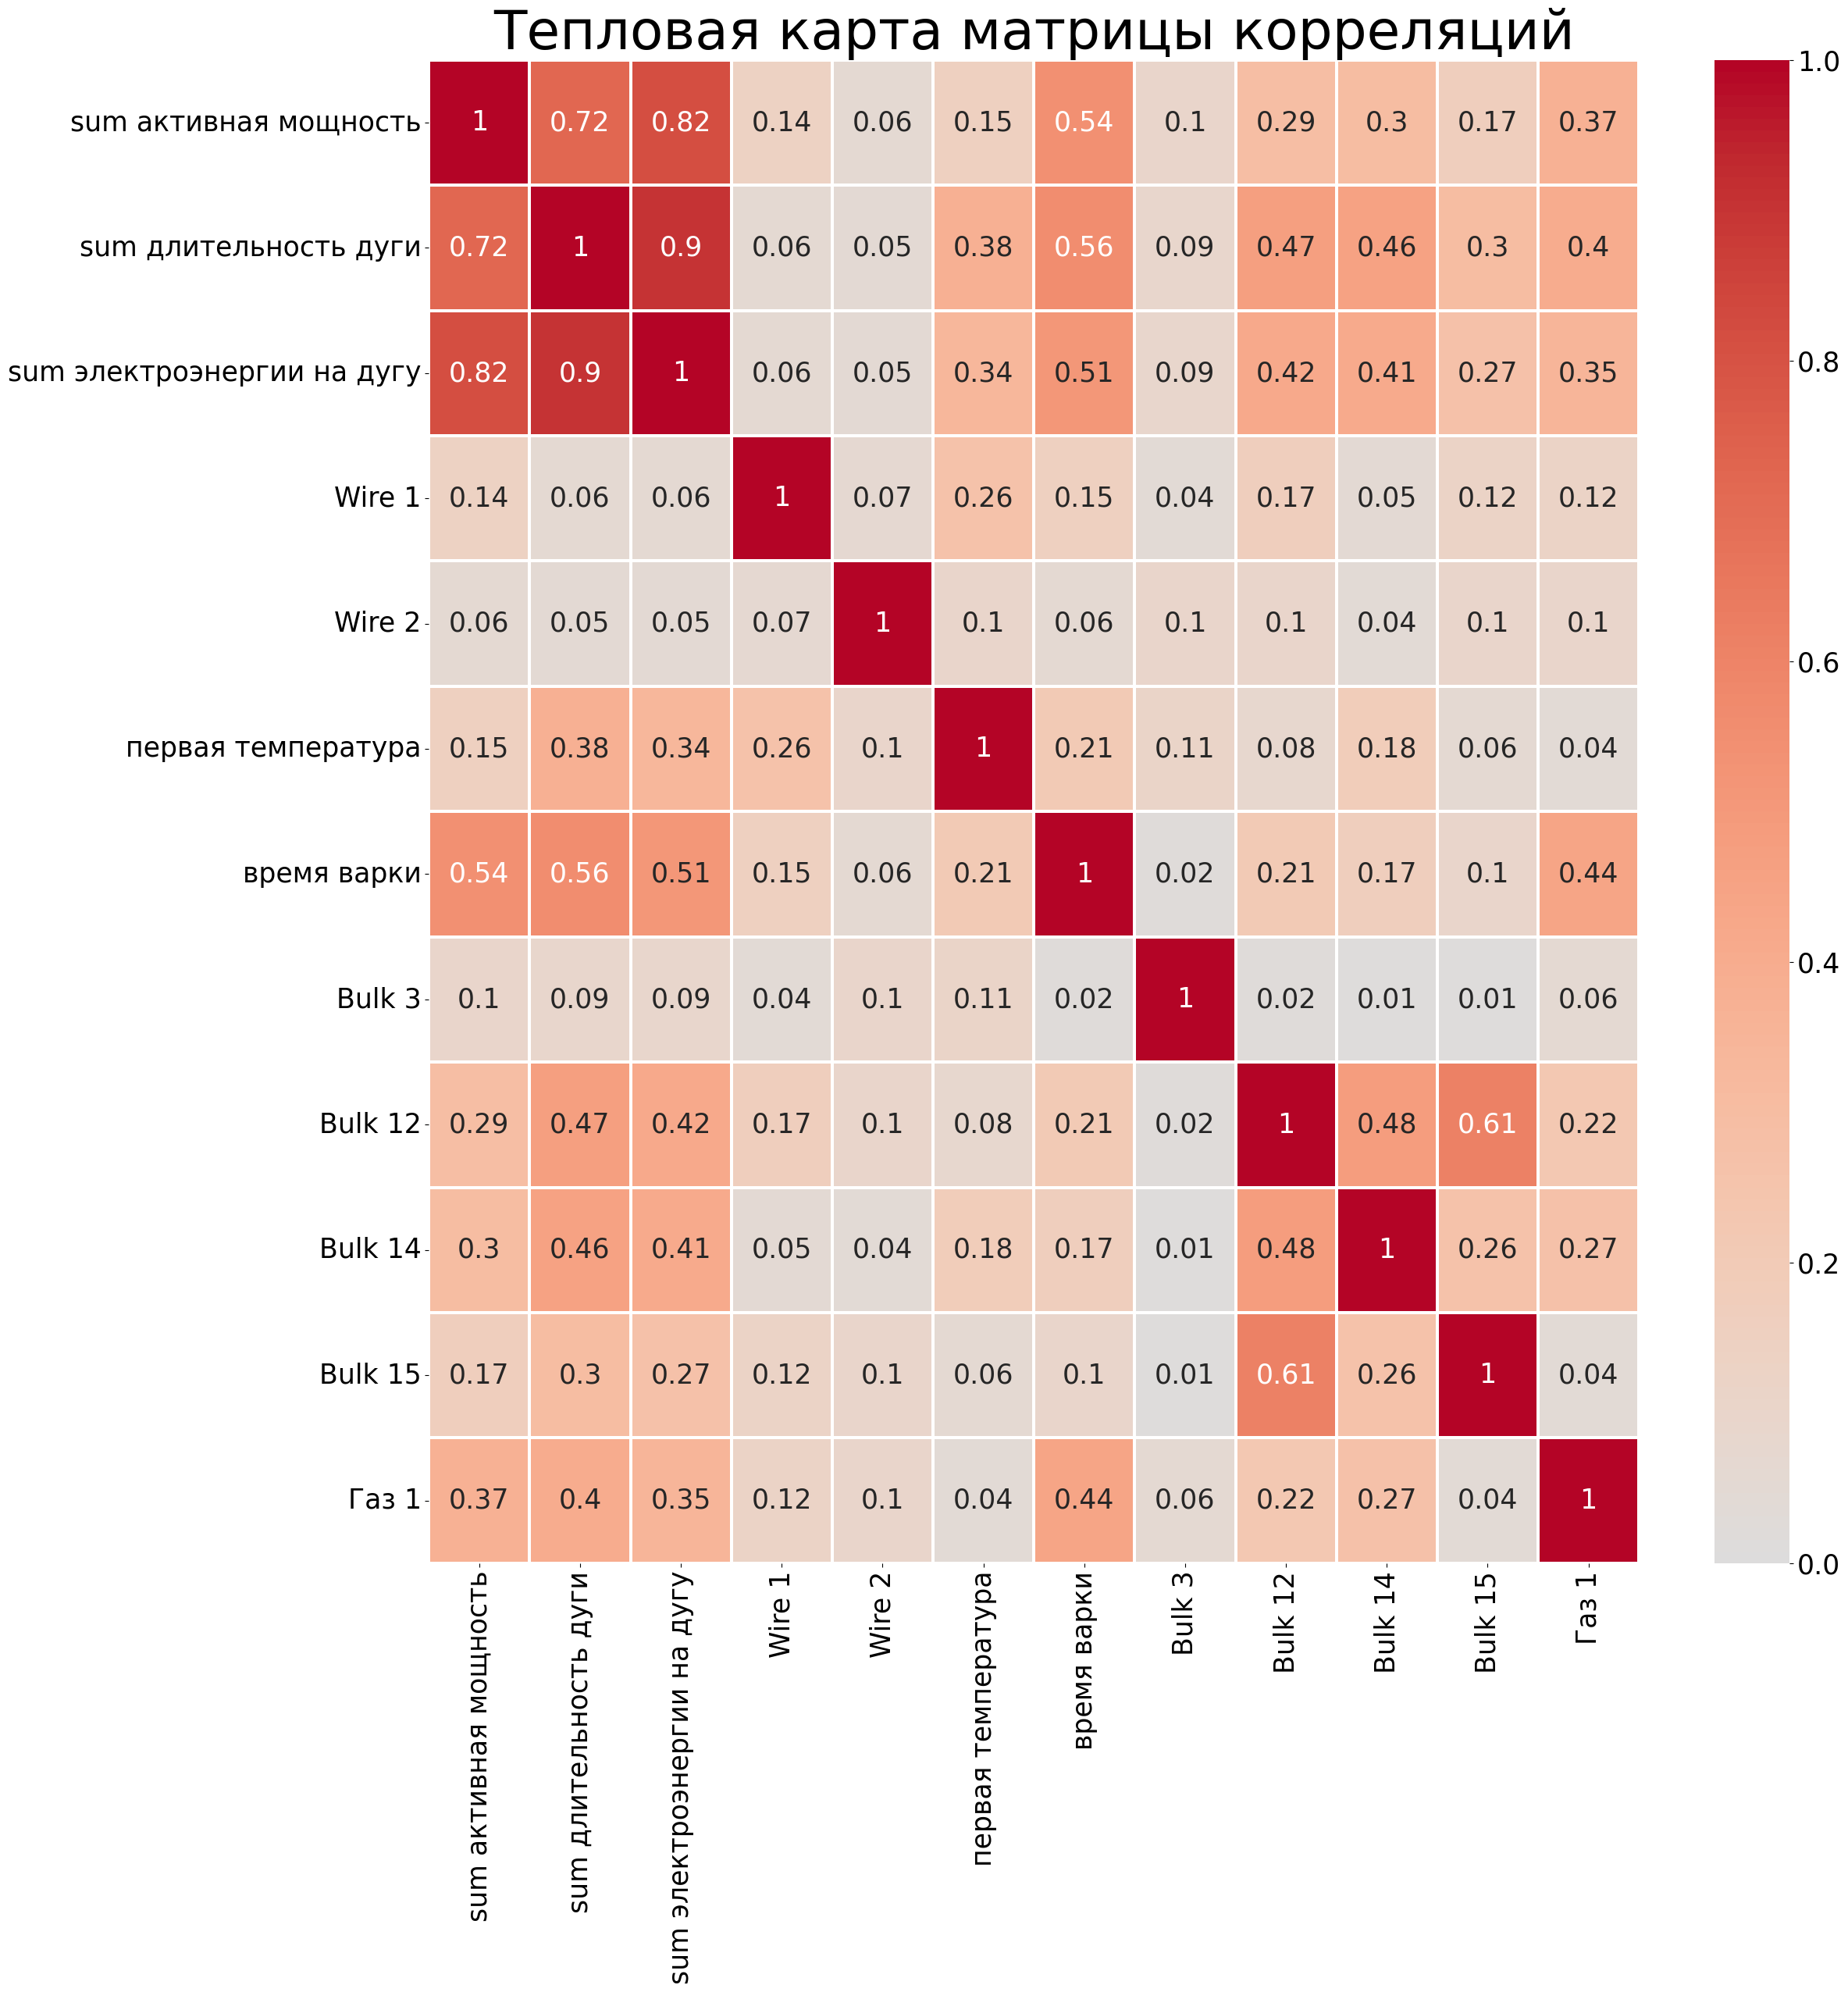

In [164]:
font = {'size': 25}
plt.rc('font', **font)

plt.figure(figsize=(25, 25))
heatmap = sns.heatmap(round(abs(features.corr()), 2),
                      annot=True,
                      cmap='coolwarm',
                      vmax=1, vmin=0, center=0,
                      linewidths=1.5,
                      fmt='.2g')
heatmap.set_title('Тепловая карта матрицы корреляций', fontsize=50);

сильно скоррелированы:
- sum длительность дуги
- Bulk 12

удалю пока только Bulk 12

In [165]:
features = features.drop('Bulk 12', axis = 1)
df = df.drop(['Bulk 12', 'key'], axis = 1)

In [166]:
df

sum активная мощность  sum длительность дуги  \
0                  3.036730                 1098.0   
1                  2.139408                  811.0   
2                  4.063641                  655.0   
3                  2.706489                  741.0   
4                  2.252950                  869.0   
...                     ...                    ...   
2320               3.168133                  723.0   
2321               4.174918                  940.0   
2322               3.605239                  569.0   
2323               3.202310                  750.0   
2324               1.737084                  883.0   

      sum электроэнергии на дугу      Wire 1    Wire 2  первая температура  \
0                     628.616930   60.059998   0.00000              1571.0   
1                     395.281800   96.052315   0.00000              1581.0   
2                     581.774624   91.160157   0.00000              1596.0   
3                     543.710274   89.063515   0.00000              1601.0   
4                     412.180480   89.238236   9.11456              1576.0   
...                          ...         ...       ...                 ...   
2320                  571.539318   89.150879   0.00000              1570.0   
2321                  675.222467  114.179527   0.00000              1554.0   
2322                  680.326674   94.086723   9.04800              1571.0   
2323                  474.918795  118.110717   0.00000              1591.0   
2324                  427.922553  110.160958  50.00528              1569.0   

      последняя температура  время варки  Bulk 3  Bulk 14  Bulk 15      Газ 1  
0                    1613.0         1714     0.0    150.0    154.0  29.749986  
1                    1602.0         1265     0.0    149.0    154.0  12.555561  
2                    1599.0         1753     0.0    152.0    153.0  28.554793  
3                    1625.0         1220     0.0    153.0    154.0  18.841219  
4                    1602.0         1536     0.0    151.0    152.0   5.413692  
...                     ...          ...     ...      ...      ...        ...  
2320                 1591.0         1380    21.0    129.0    223.0   7.125735  
2321                 1591.0         1705     0.0    129.0    226.0   9.412616  
2322                 1589.0          962     0.0    124.0    226.0   6.271699  
2323                 1594.0         1520    90.0    129.0    207.0  14.953657  
2324                 1603.0         1537    47.0    126.0    227.0  11.336151  

[2325 rows x 12 columns]

## исследование итогового датасета

In [167]:
print('пример данных')
display(df.head(2))
print('\n\nобщая информация')
df.info()
print('\n\nстатистика распределения')
display(df.describe())
print('\n\nполные дубли')
display(df.duplicated().sum())
print('\n\nпропуски')
display(df.isna().sum())

пример данных


sum активная мощность  sum длительность дуги  sum электроэнергии на дугу  \
0               3.036730                 1098.0                   628.61693   
1               2.139408                  811.0                   395.28180   

      Wire 1  Wire 2  первая температура  последняя температура  время варки  \
0  60.059998     0.0              1571.0                 1613.0         1714   
1  96.052315     0.0              1581.0                 1602.0         1265   

   Bulk 3  Bulk 14  Bulk 15      Газ 1  
0     0.0    150.0    154.0  29.749986  
1     0.0    149.0    154.0  12.555561



общая информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sum активная мощность       2325 non-null   float64
 1   sum длительность дуги       2325 non-null   float64
 2   sum электроэнергии на дугу  2325 non-null   float64
 3   Wire 1                      2325 non-null   float64
 4   Wire 2                      2325 non-null   float64
 5   первая температура          2325 non-null   float64
 6   последняя температура       2325 non-null   float64
 7   время варки                 2325 non-null   int64  
 8   Bulk 3                      2325 non-null   float64
 9   Bulk 14                     2325 non-null   float64
 10  Bulk 15                     2325 non-null   float64
 11  Газ 1                       2325 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 236.1 KB


статистика распределе

sum активная мощность  sum длительность дуги  \
count            2325.000000            2325.000000   
mean                3.126116             808.035269   
std                 1.220263             340.829330   
min                 0.267676              57.000000   
25%                 2.296007             581.000000   
50%                 3.036303             778.000000   
75%                 3.834300             993.000000   
max                12.375636            4189.000000   

       sum электроэнергии на дугу       Wire 1       Wire 2  \
count                 2325.000000  2325.000000  2325.000000   
mean                   539.273463   102.412198    17.605637   
std                    257.298107    43.535263    33.642919   
min                     26.187544     0.000000     0.000000   
25%                    368.206194    73.207679     0.000000   
50%                    508.453259   101.087998     0.000000   
75%                    679.062253   128.069763    23.102560   
max                   3718.054401   330.314424   282.780152   

       первая температура  последняя температура   время варки       Bulk 3  \
count         2325.000000            2325.000000   2325.000000  2325.000000   
mean          1587.365161            1593.366022   2323.419785    47.296774   
std             23.623144              11.209581   1385.569302    75.228262   
min           1519.000000            1541.000000    339.000000     0.000000   
25%           1571.000000            1587.000000   1581.000000     0.000000   
50%           1587.000000            1593.000000   2046.000000     0.000000   
75%           1603.000000            1598.000000   2793.000000    80.000000   
max           1660.000000            1653.000000  23674.000000   454.000000   

           Bulk 14      Bulk 15        Газ 1  
count  2325.000000  2325.000000  2325.000000  
mean    153.971613   120.026667    11.378942  
std      81.398153    84.674380     6.395632  
min       0.000000     0.000000     0.008399  
25%     105.000000     0.000000     7.282948  
50%     149.000000   107.000000    10.100950  
75%     204.000000   204.000000    14.217691  
max     636.000000   405.000000    77.995040



полные дубли


0



пропуски


sum активная мощность         0
sum длительность дуги         0
sum электроэнергии на дугу    0
Wire 1                        0
Wire 2                        0
первая температура            0
последняя температура         0
время варки                   0
Bulk 3                        0
Bulk 14                       0
Bulk 15                       0
Газ 1                         0
dtype: int64

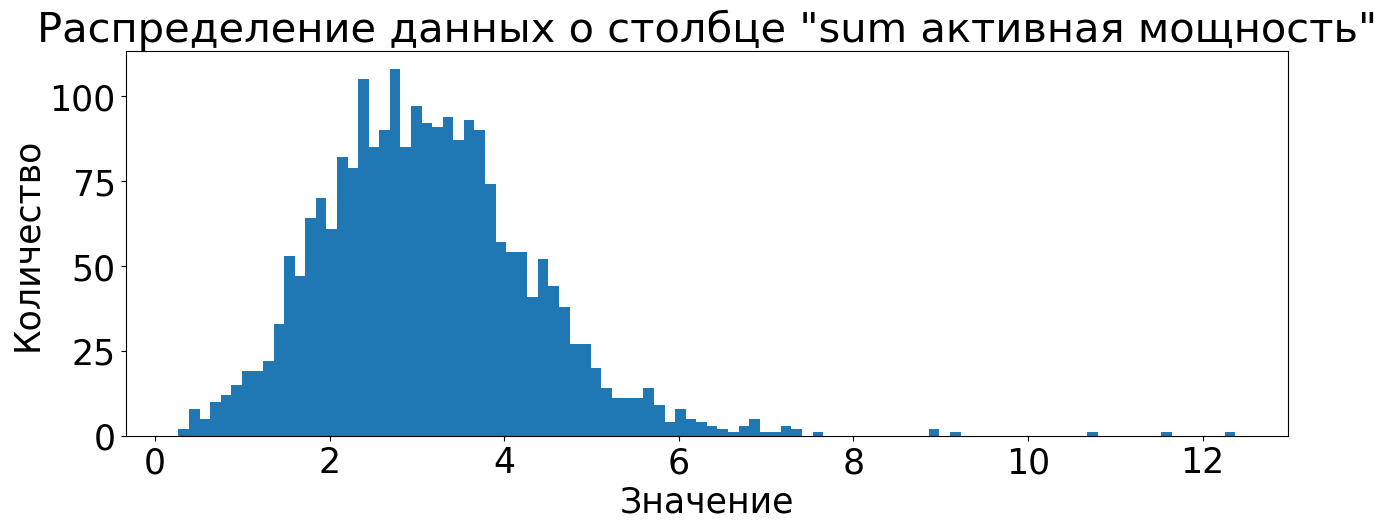

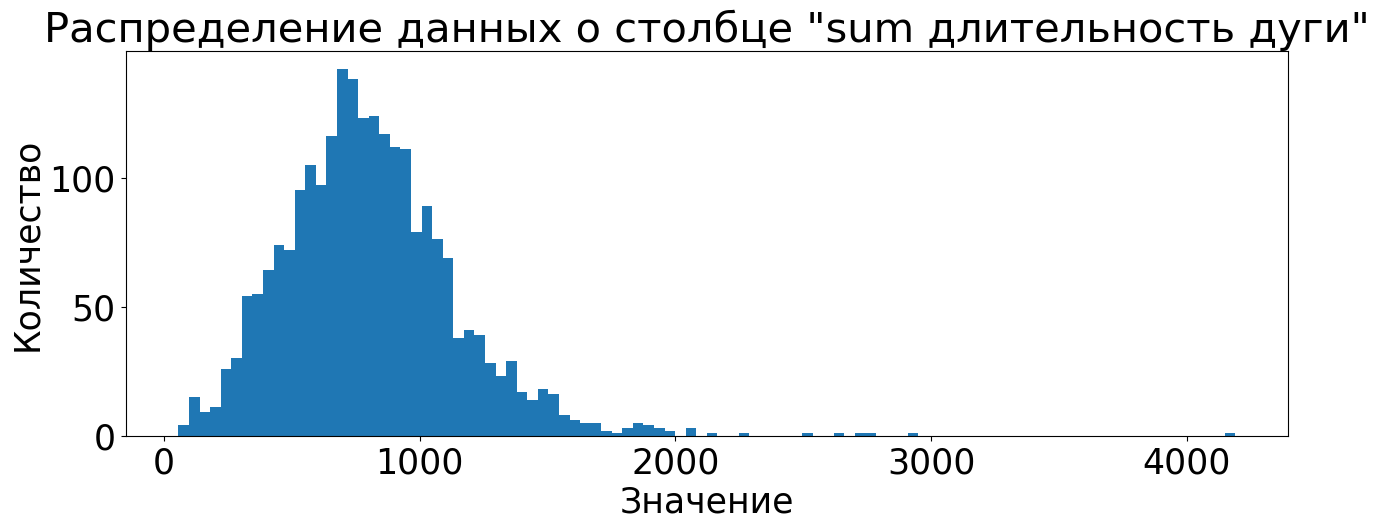

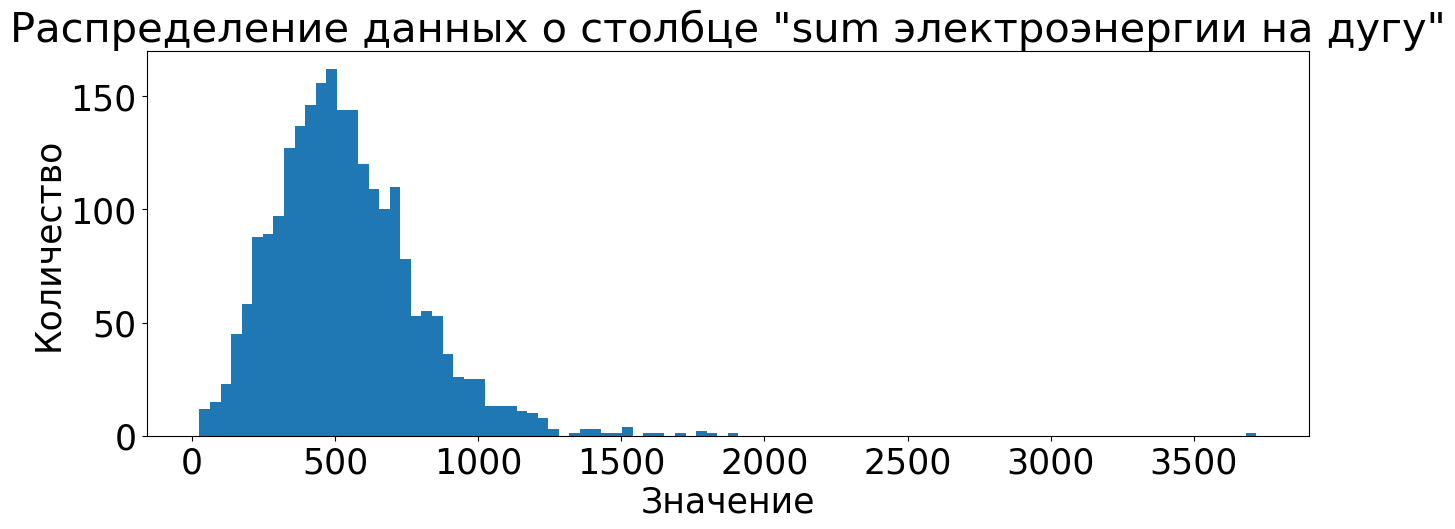

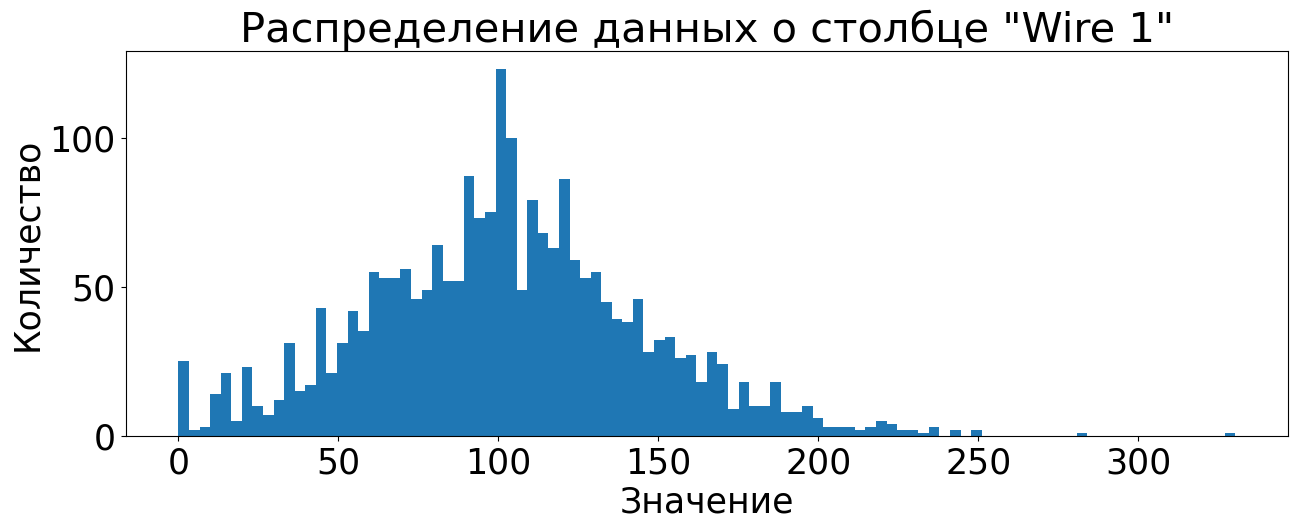

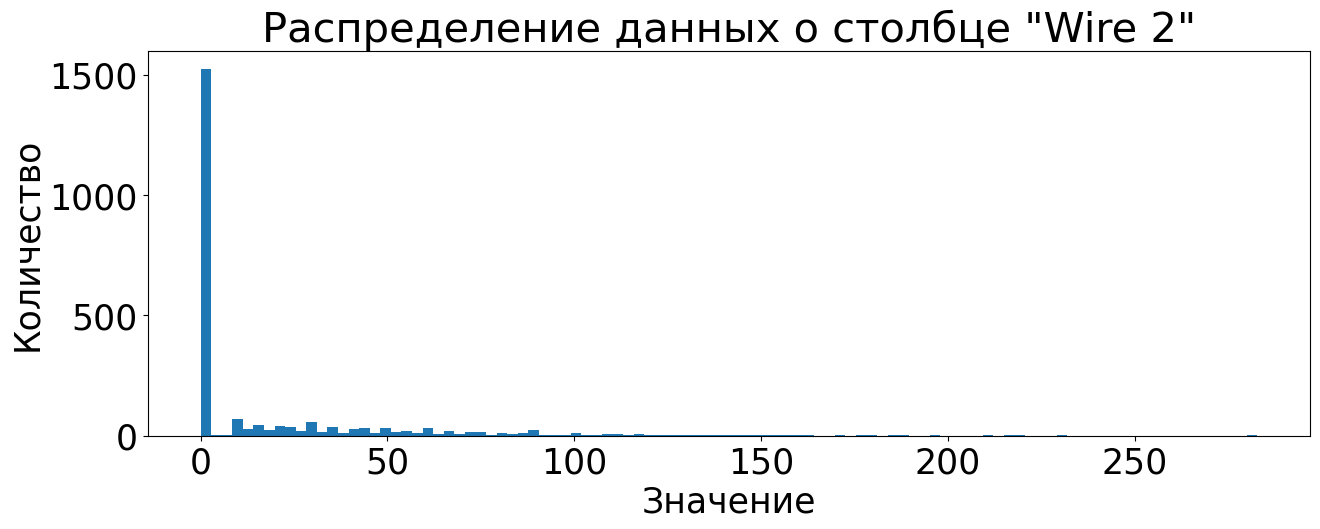

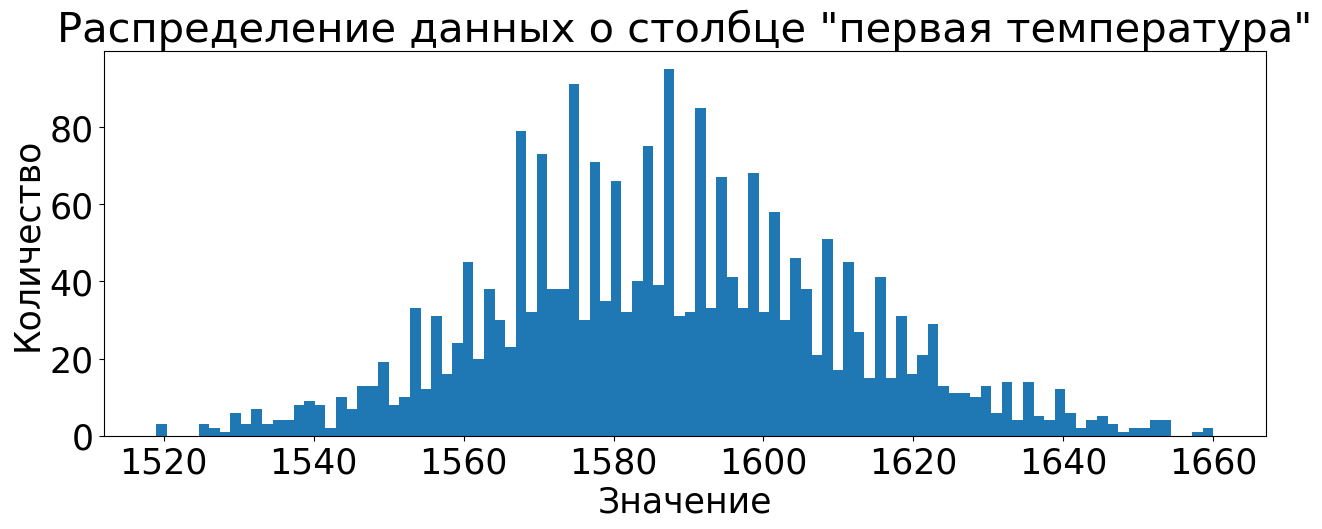

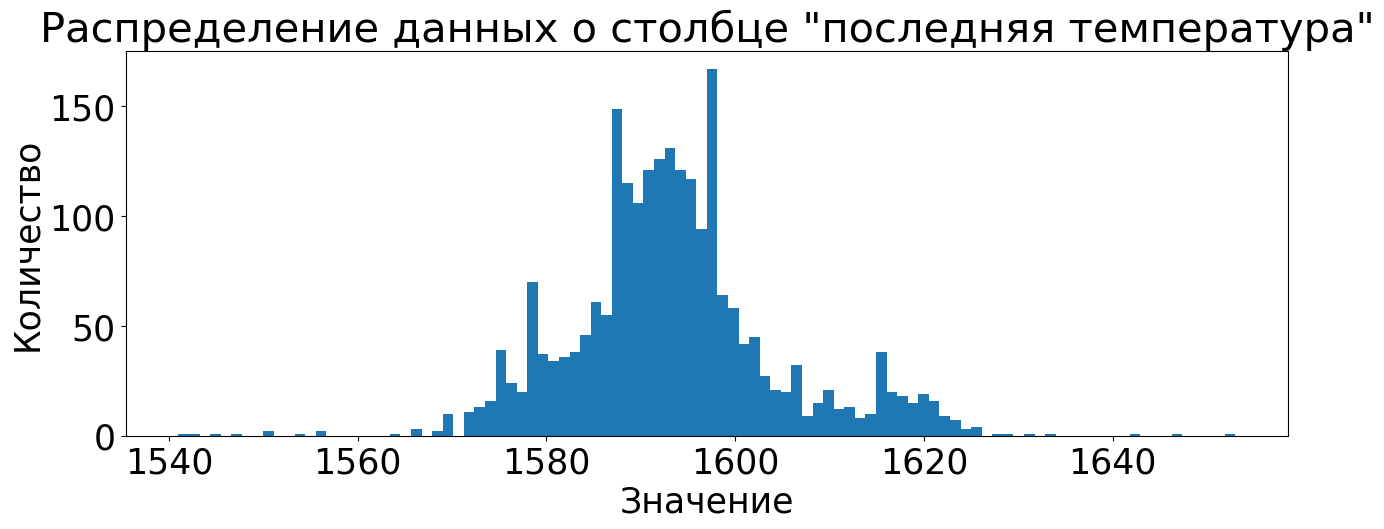

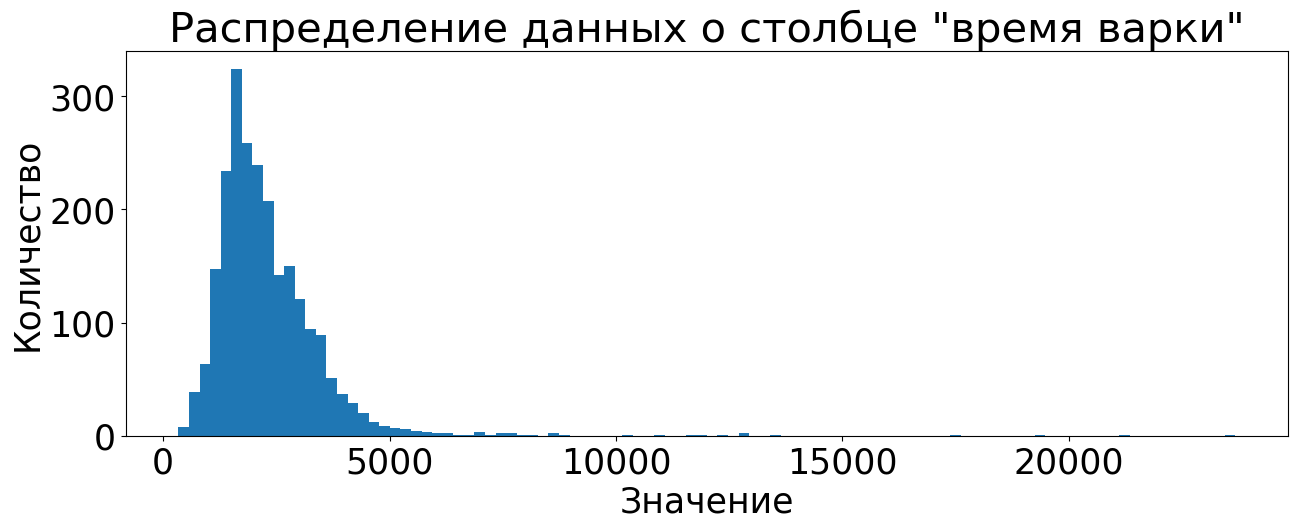

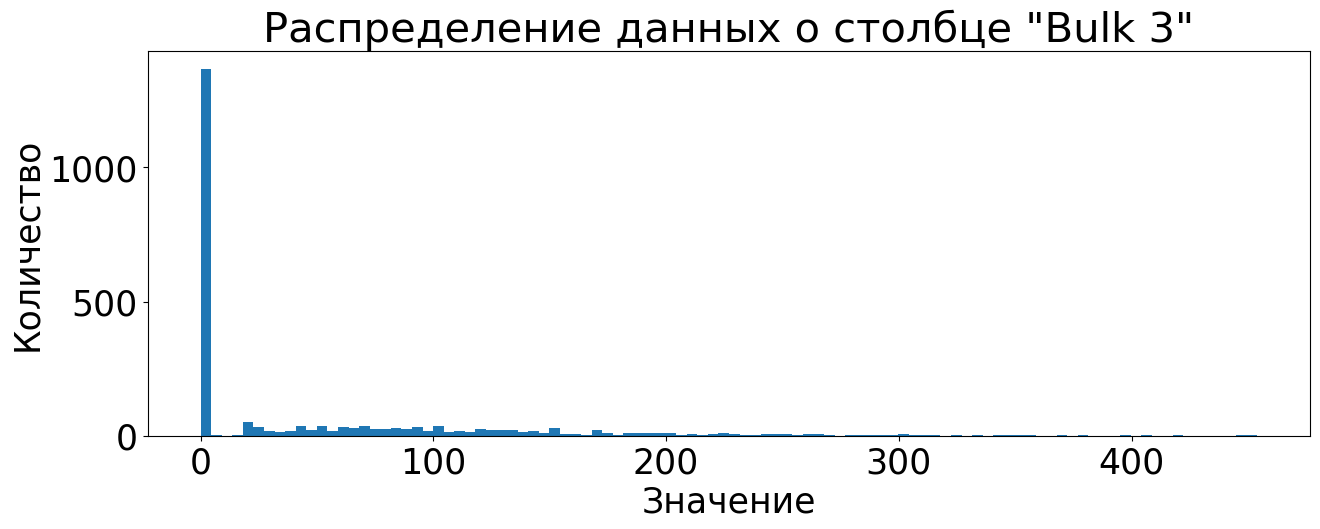

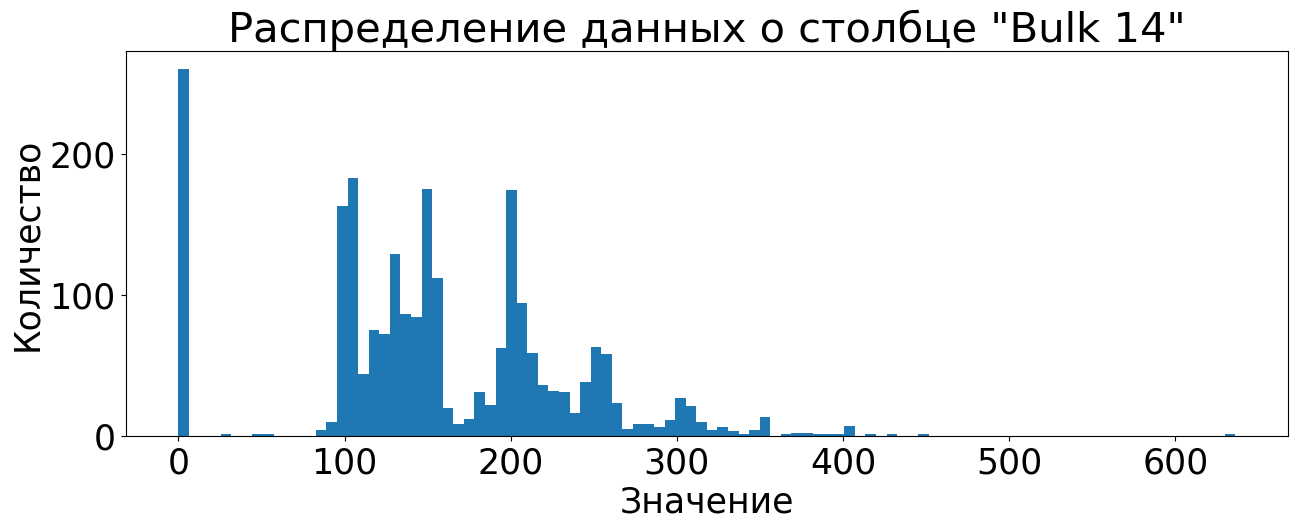

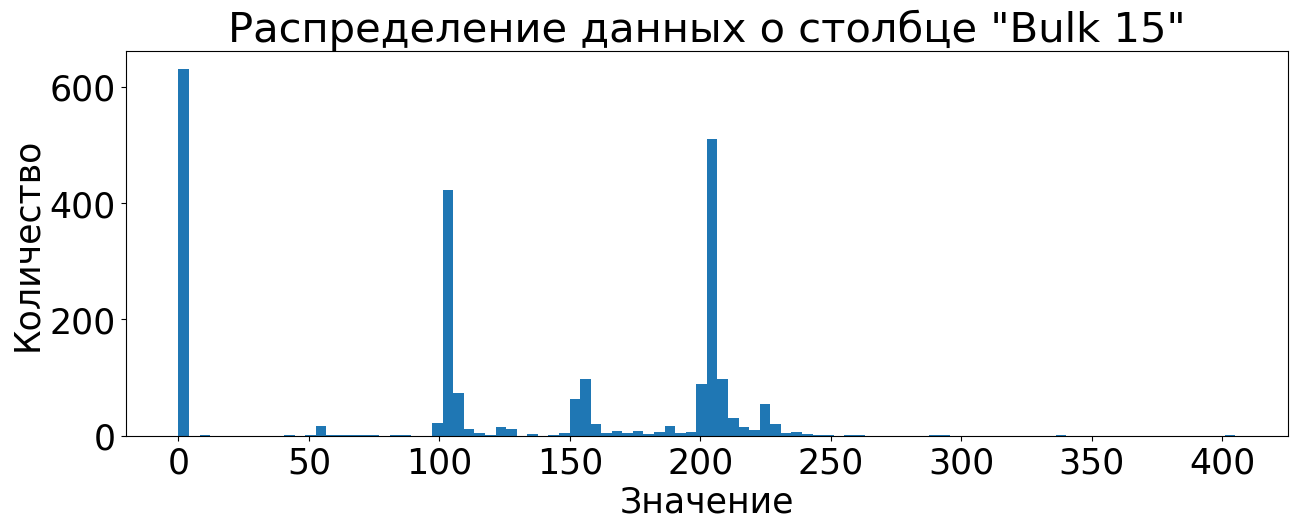

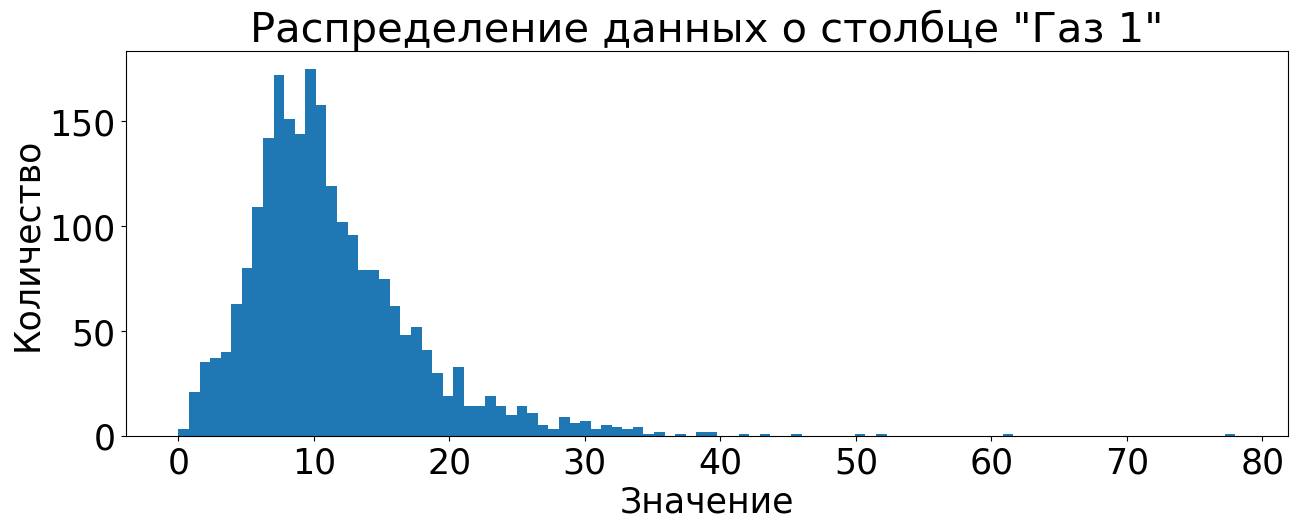

In [168]:
for i in df:
    plt.figure(figsize=(15,5))
    df[i].plot(kind='hist', bins=100)
    plt.title(f'Распределение данных о столбце "{i}"')
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show()

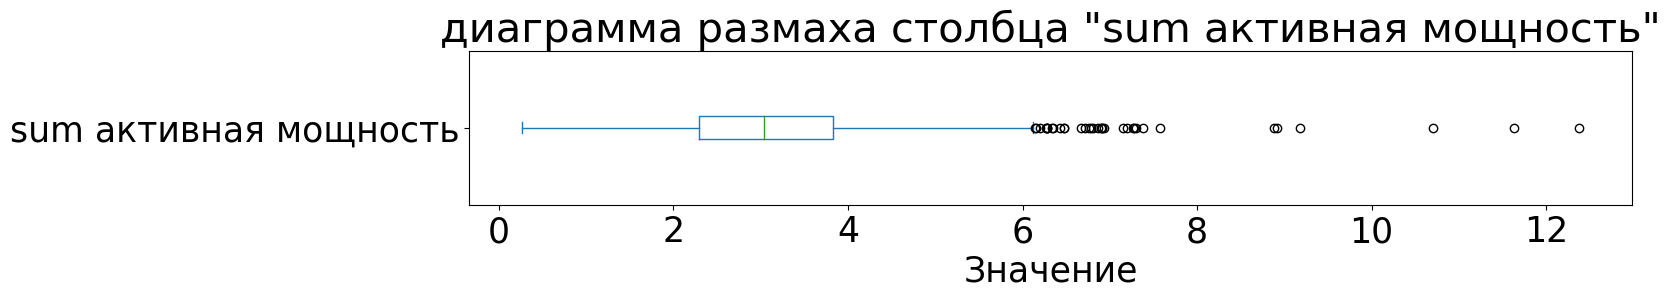

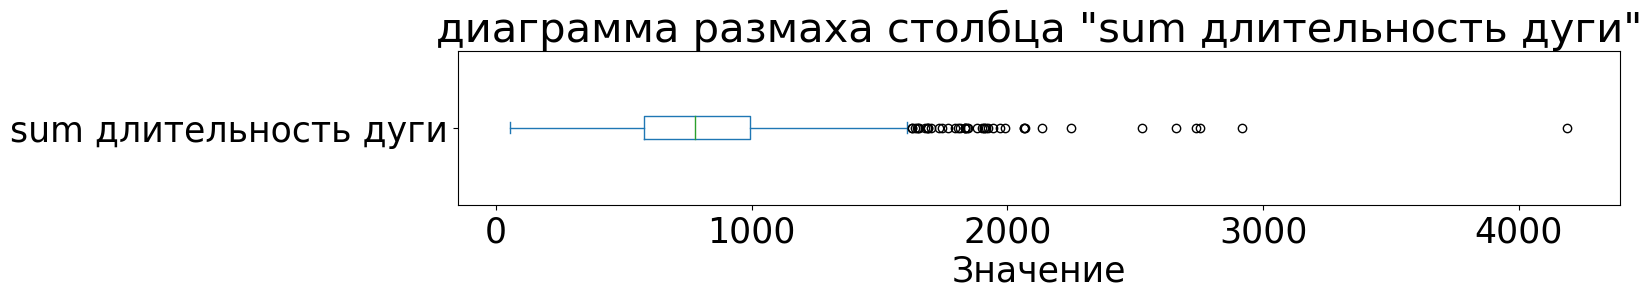

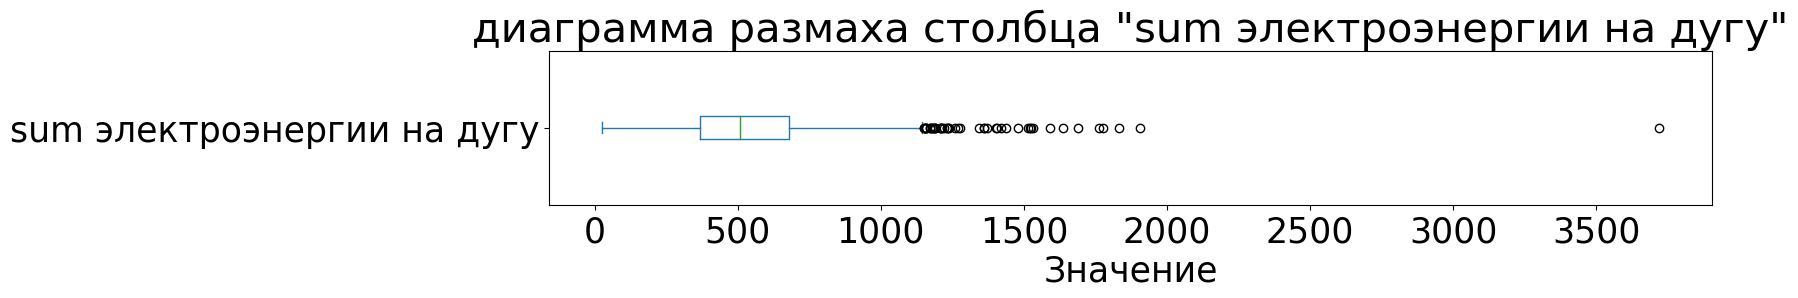

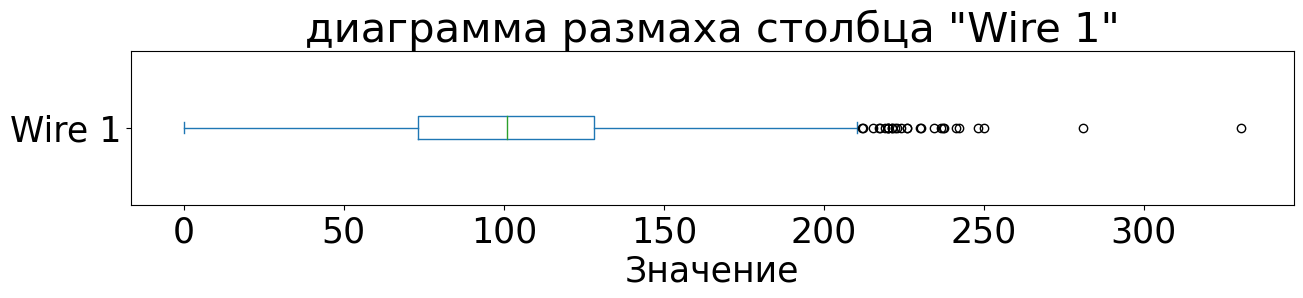

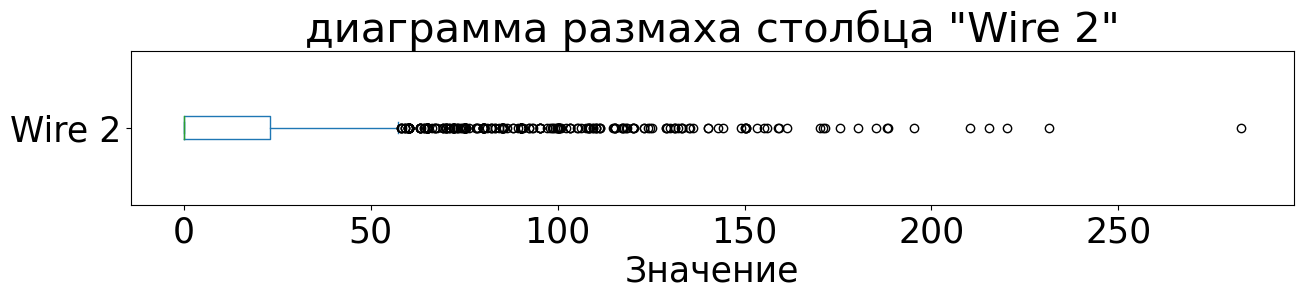

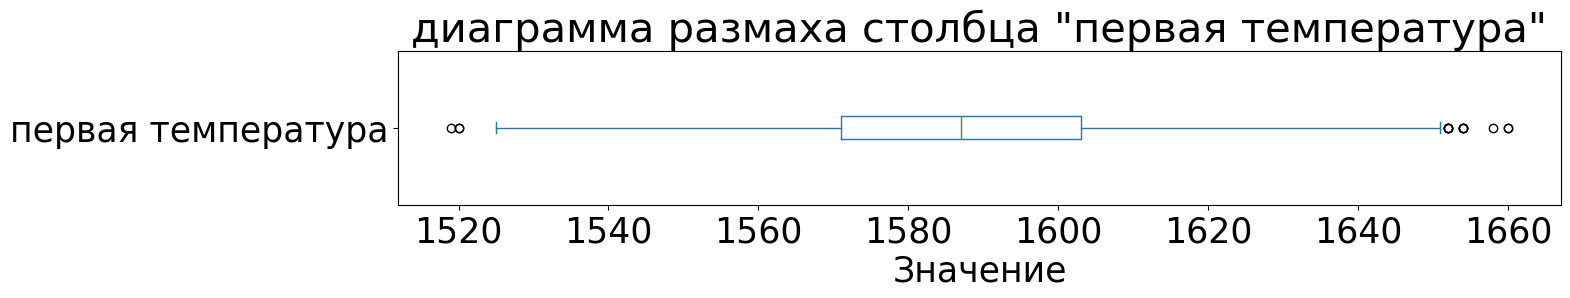

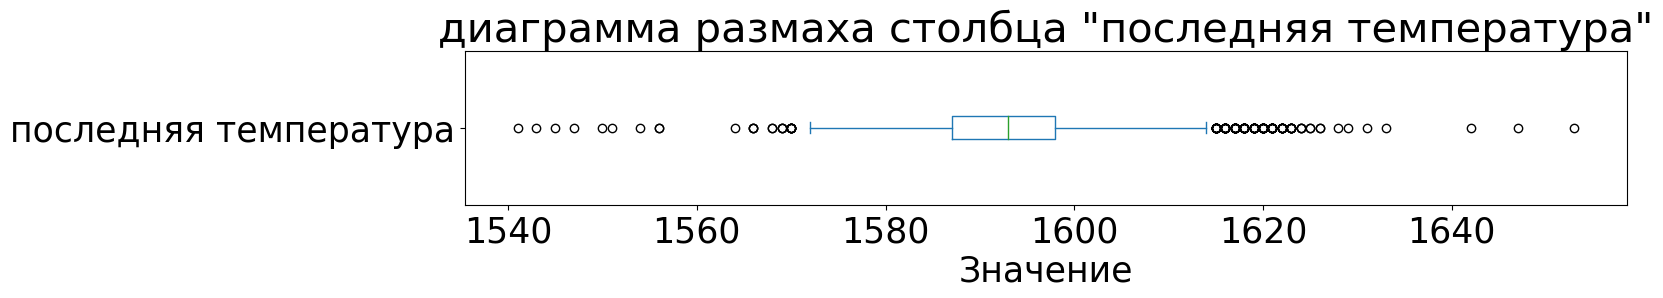

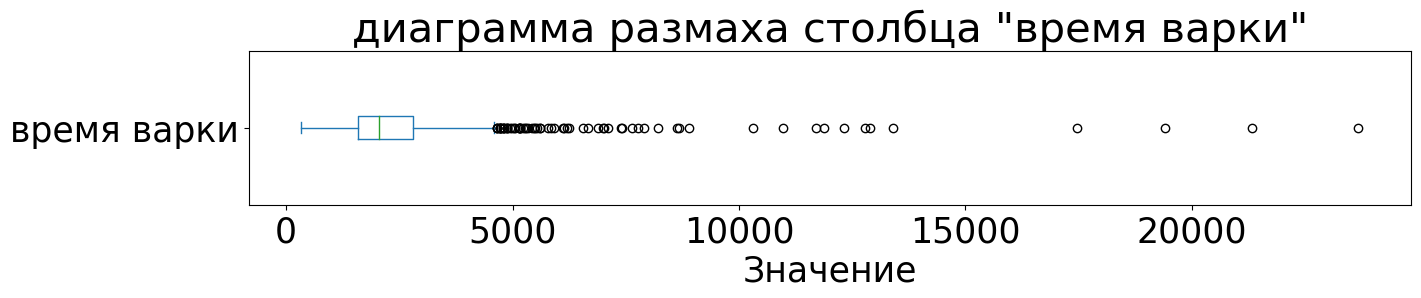

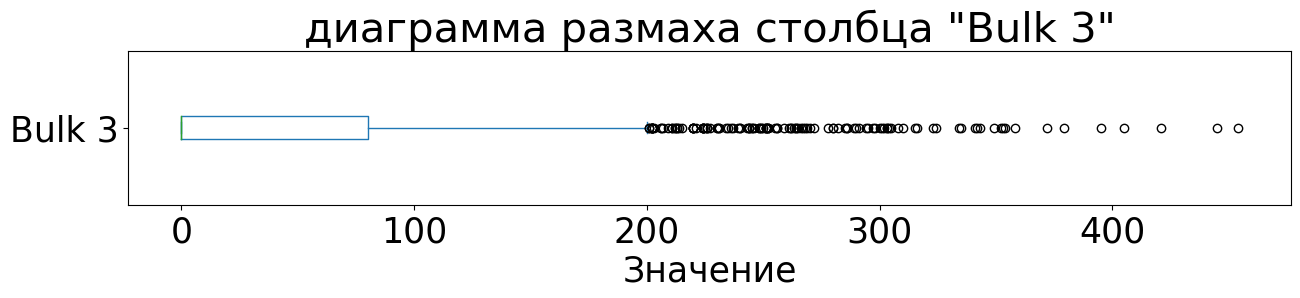

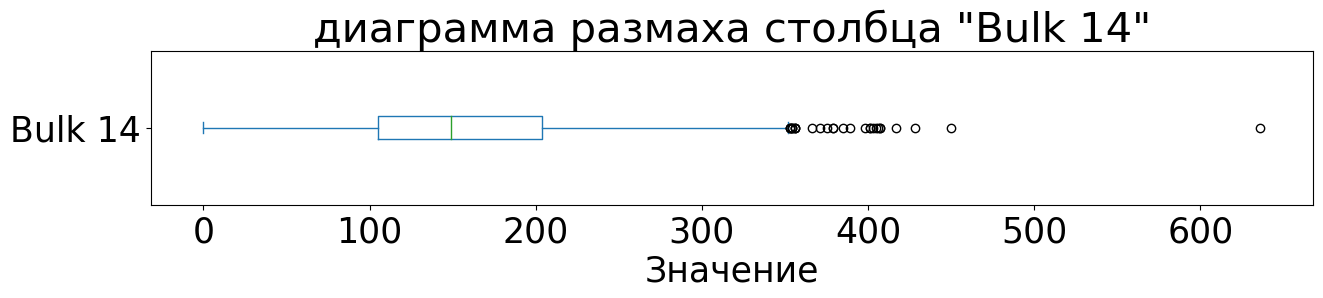

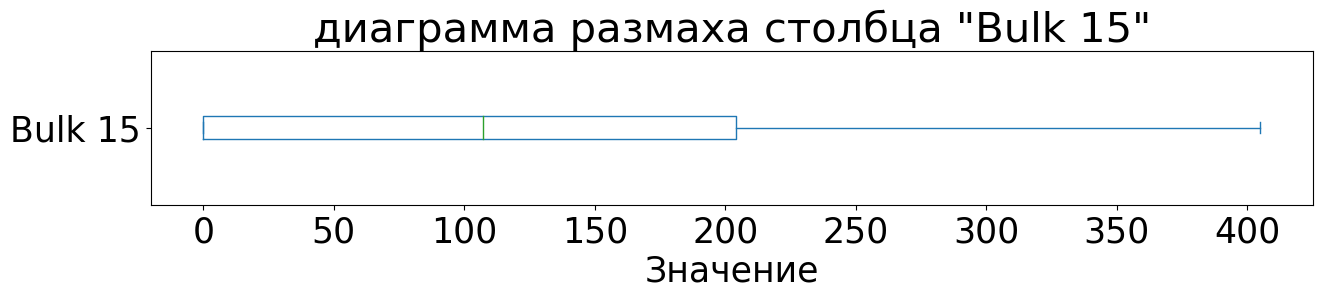

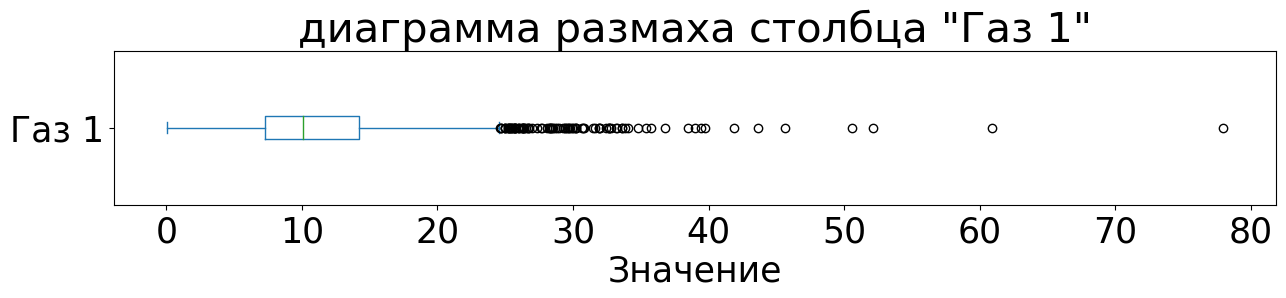

In [169]:
for i in df:
    plt.figure(figsize=(15,2))
    df[i].plot(kind='box', vert = False)
    plt.title(f'диаграмма размаха столбца "{i}"')
    plt.xlabel('Значение')
    plt.show()

в итоговом датасете 2329 строк, 12 столбцов, есть выбросы, нет пропусков

In [170]:
train_features, test_features, train_target, test_target = train_test_split(features, target,
                                                                            test_size=TEST_SIZE, 
                                                                            random_state=RANDOM_STATE)

In [171]:
scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

# обучение моделей

In [172]:
%%time
model_cb = CatBoostRegressor(random_state=RANDOM_STATE)
param_cb = {
    'iterations': [100, 110],
    'learning_rate': [0.08, 0.1],
    'depth': [6, 10]
}
searcher_cb = RandomizedSearchCV(model_cb, param_cb, cv=4, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE)
searcher_cb.fit(train_features, train_target)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 10.9693839	total: 153ms	remaining: 15.2s
1:	learn: 10.7844033	total: 155ms	remaining: 7.62s
2:	learn: 10.6067474	total: 158ms	remaining: 5.09s
3:	learn: 10.4494149	total: 160ms	remaining: 3.83s
4:	learn: 10.3035035	total: 162ms	remaining: 3.08s
5:	learn: 10.1632666	total: 164ms	remaining: 2.57s
6:	learn: 10.0278914	total: 166ms	remaining: 2.21s
7:	learn: 9.9055621	total: 168ms	remaining: 1.94s
8:	learn: 9.7937803	total: 170ms	remaining: 1.72s
9:	learn: 9.6855340	total: 172ms	remaining: 1.55s
10:	learn: 9.5800359	total: 175ms	remaining: 1.41s
11:	learn: 9.4766545	total: 177ms	remaining: 1.29s
12:	learn: 9.3710373	total: 179ms	remaining: 1.2s
13:	learn: 9.2662528	total: 181ms	remaining: 1.11s
14:	learn: 9.1667216	total: 183ms	remaining: 1.03s
15:	learn: 9.0947919	total: 184ms	remaining: 968ms
16:	learn: 9.0155261	total: 186ms	remaining: 910ms
17:	learn: 8.9367584	total: 188ms	remaining: 858ms
18:	learn: 8.8620533	total: 191ms	remaining: 813ms
19:	learn: 8.8140793	total: 193ms	r

RandomizedSearchCV(cv=4,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000002435917A280>,
                   param_distributions={'depth': [6, 10],
                                        'iterations': [100, 110],
                                        'learning_rate': [0.08, 0.1]},
                   random_state=161023, scoring='neg_mean_absolute_error')

т.к. менять датасет из-за однолинейной регресси я не хочу, добавил лассо-регуляризацию. другой путь это удалить фичи с корреляцией >0.9

In [56]:
alpha_values = {'alpha':[0.1 for i in range(len(features.columns))]}
lasso = GridSearchCV(Lasso(),
                     alpha_values,
                     scoring = 'neg_mean_absolute_error',
                     cv = 4)
lasso.fit(train_features,train_target)
print('The best value of alpha is:', lasso.best_params_)
print('The best score for the best Lasso estimator is:', lasso.best_score_*-1)

The best value of alpha is: {'alpha': 0.1}
The best score for the best Lasso estimator is: 6.66369911968985


In [57]:
model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
param_dt = { 'max_depth': [1, 10],
               'min_samples_leaf': [1, 10]}

searcher_dt = GridSearchCV(model_dt, param_dt, cv=4, scoring='neg_mean_absolute_error')
searcher_dt.fit(train_features, train_target)

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=161023),
             param_grid={'max_depth': [1, 10], 'min_samples_leaf': [1, 10]},
             scoring='neg_mean_absolute_error')

# сравнение моделей

In [58]:
print('CatBoostRegressor best_score = ', searcher_cb.best_score_*-1)
print('DecisionTreeRegressor best_score = ', searcher_dt.best_score_*-1)
print('LinearRegression Lasso best_score = ', lasso.best_score_*-1)

CatBoostRegressor best_score =  6.1121112075186605
DecisionTreeRegressor best_score =  7.553889646588653
LinearRegression Lasso best_score =  6.66369911968985


наилучшее значение у CatBoostRegressor. его возьму для теста

In [59]:
print('test MAE cb:', mean_absolute_error(searcher_cb.predict(test_features), test_target))

test MAE cb: 6.133197166379213


In [60]:
# константная модель на train:
const_pred = pd.Series([train_target.median() for i in range(len(train_target))])
print('test MAE constant:', mean_absolute_error(const_pred, train_target))

# константная модель на test:
const_pred = pd.Series([test_target.median() for i in range(len(test_target))])
print('test MAE constant:', mean_absolute_error(const_pred, test_target))

test MAE constant: 8.029209621993127
test MAE constant: 8.109777015437393


In [61]:
a = pd.DataFrame()
a['features'] = features.columns
a['importance'] = searcher_cb.best_estimator_.feature_importances_
a=a.sort_values('importance', ascending=False)
a

features  importance
5           первая температура   28.040318
1        sum длительность дуги   21.025695
6                  время варки   12.479367
3                       Wire 1    9.098461
2   sum электроэнергии на дугу    7.323637
8                      Bulk 14    5.241086
4                       Wire 2    5.051360
9                      Bulk 15    4.491006
10                       Газ 1    4.099185
0        sum активная мощность    2.228009
7                       Bulk 3    0.921876

CatBoostRegressor показывает достаточную точность на тестовой выборке. точность выше чем усановленный порог и выше чем у константной модели с медианой. считаю задачу выполненной.

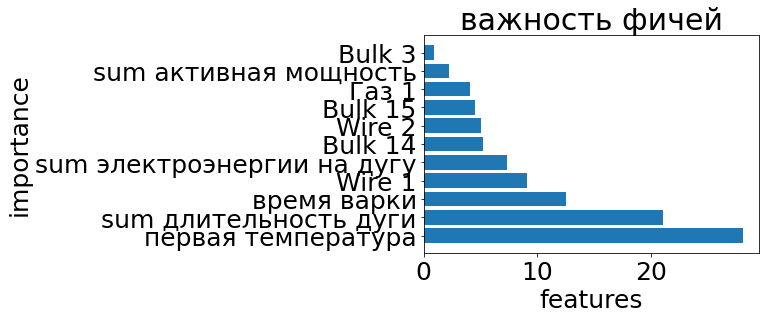

In [62]:
plt.barh(a['features'], a['importance'])
plt.title('важность фичей')
plt.xlabel('features')
plt.ylabel('importance')
plt.show()

<b>вывод:</b><br>
были обучены три модели<br>
- CatBoostRegressor (+RandomizedSearchCV)
- LinearRegression (+cross_val_score)
- DecisionTreeRegressor (+GridSearchCV)

лучший результат показал алгоритм CatBoostRegressor.<br>
на тестовой выборке у данного алгоритма результат лучше порога и лучше кнстантной модели.<br>
показана гистограмма важности фичей<br>
наиболее важными являются
- первая температура
- суммарная длительность дуги
- время варки

# Отчёт по решению

Согласно [плана](#plan) пункты 
- 1 (описание проекта и постановка задачи)
- 2 (изучение данных)
- 3 (предобработка данных)
- 4 (подготовка данных)
- 5 (подбор моделей)
- 6 (тестирование моделей)

были выполнены. в пункте 6 был проведен также анализ важности фичей, что не входит в тестирование моделей, но являлось обязательным условием.<br>
при изучении данных были обнаружены:
- пропуски (в датасте с добавками заменены на 0, в остальных пришлось удалять партии)
- температура меньше температуры плавления (пришлось удалять партии)

а также отрицательная реактивная мощность (столбец не использовал полностью. минус потенциально полезная фича)<br>
при объединении данных в один датасет оставил только те партии, которые входят во все начальные датасеты (то есть потеряны датасеты, которые не входят хотябы в один начальный датасет)<br><br>

ключевыми шагами считаю предобработку данных; и обучение моделей, выбор лучшей, тестирование

<b>в предобработке данных:</b><br>
приведены типы данных в столбцах<br>
из датасета с температурой:

- исключены партии с температурой < 1450
- исключены партии с пропусками
- исключены партии с одним замером
- выявлены в партиях первый и последний замер
- добавлена фича "время варки"

в датасете с добавками:
- удалены столбцы с содержание пропусков > 67%
- оставшиеся пропуски заменены на 0

в датасете с электродами:
- добавлена фича суммарная на партию длительность дуги
- добавлена фича суммарные на партию затраты электроэнергии
- добавлена фича суммарная на партию активная мощность
- выведена матрица корреляций фичей
- поле чего удалена скоррелированная фича Bulk 12

<b>при обучении моделей:</b>
- с помощью RandomizedSearchCV были подобраны гиперпараметры CatBoostRegressor
- с помощью GridSearchCV были подобраны гиперпараметры lasso регуляризованной регрессии
- с помощью GridSearchCV были подобраны гиперпараметры DecisionTreeRegressor

при сравнении моделей был выявлен наилучший ML алгоритм - CatBoostRegressor
при тестировании целевая метрика (MAE) на тестовой выборке = 6.13 что является достаточным по условиям заказчика (< 6.8) и лучше чем у константной модели, сформированной по медиане (<8)

<b>признаки, которые использовали для обучения:</b> и их предобработка
- суммарная активная мощность
- суммарная длительность дуги
- суммарные затраты электроэнергии на дугу
- Wire 1
- Wire 2
- первая температура
- последняя температура
- время варки
- Bulk 3
- Bulk 14
- Bulk 15
- Газ 1

помимо очистки данных так же было проведено масштабирование с помощью StandardScaler<br>
итоговой моделью принят CatBoostRegressor со следующими гиперпараметрами:
- learning_rate= 0.1
- iterations= 110
- depth= 6
и RANDOM_STATE = 161023

<b>рекомендации по улучшению решения:</b><br>
в дальнейшем при необходимости улучшить метрику предполагаю либо рассматривать более широки подбор гиперпараметров, либо рассмотреть алгоритмы, не вшедшие в данную работу (RandomForestRegressor, полиномиальная регрессия, нейросети, etc) либо добавление фичей (в данных об электродах рассмотреть не только суммарную актиную мощность,длительность дуги и затраты электроэнергии, но и минимальные, максимальные, медианные и т.д. так же в данных о подаче сыпучих материалов (объём) рассмотреть добавение столбца с суммой всех выкинутых добавок и т.д.)